In [ ]:
import os
os.chdir(r'G:\My Drive\HEURISTICS\Ghana_predictions\Beliefs')

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample documents
documents = [
    "I like to play football",
    "Football is my favorite sport",
    "I enjoy playing basketball",
    "Basketball is a great game"
]

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

# Number of topics
num_topics = 3

# Perform NMF
nmf = NMF(n_components=num_topics)
nmf_matrix = nmf.fit_transform(tfidf_matrix)

# Get the feature names (words)
feature_names = vectorizer.get_feature_names()

# Print the top words for each topic
for topic_idx, topic in enumerate(nmf.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")


Topic 1: great, game, is, basketball, sport
Topic 2: football, to, play, like, sport
Topic 3: playing, enjoy, basketball, great, game


c:\Users\Janet.Mutuku\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
c:\Users\Janet.Mutuku\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from gensim import corpora, models

# Sample documents
documents = [
    "I like to play football",
    "Football is my favorite sport",
    "I enjoy playing basketball",
    "Basketball is a great game"
]

# Tokenize the documents
tokenized_documents = [doc.lower().split() for doc in documents]

# Create a dictionary of the tokenized documents
dictionary = corpora.Dictionary(tokenized_documents)

# Convert the tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Number of topics
num_topics = 2

# Perform PLSA
plsa = models.PlsiModel(corpus, num_topics=num_topics)

# Print the top words for each topic
for topic in range(num_topics):
    top_words = plsa.show_topic(topic, topn=5)
    top_words = [word for word, _ in top_words]
    print(f"Topic {topic+1}: {', '.join(top_words)}")


AttributeError: partially initialized module 'smart_open' has no attribute 'local_file' (most likely due to a circular import)

In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import glob
import nltk

nltk.download('punkt')
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy  # For preprocessing
import string
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer

import geopandas as gpd
from shapely.geometry import Point
import folium
import ast

from tqdm import tqdm
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")
from gensim.models.phrases import Phrases, Phraser
#from sklearn.feature_extraction.text import TfiextractedVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import os
import pytz
from shapely.geometry import Point


import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# Preprocessing

We keep only two columns:
* `raw_character_text`: the character who speaks (can be useful when monitoring the preprocessing steps)
* `spoken_words`: the raw text from the line of dialogue

We do not keep `normalized_text` because we want to do our own preprocessing.

In [ ]:
# #version two of the document
# # Define the directory path where the TSV files are located
# directory = '/content/drive/MyDrive/HEURISTICS/Ghana_predictions/Beliefs/ghana_Galamsey-web-2500_beliefs_and_objective_info_with_sentiment-with-loc/'

# # Get the file paths of all TSV files in the directory
# tsv_files = glob.glob(directory + '*.tsv')

# # Create an empty list to store the DataFrames
# dataframes = []

# # Read each TSV file and append its DataFrame to the list
# for file in tsv_files:
#     extracted = pd.read_csv(file, delimiter='\t',index_col=0)


#     extracted = extracted.dropna()
#     dataframes.append(extracted)

# # Concatenate all DataFrames into a single DataFrame
# combined_extracted_v2 = pd.concat(dataframes).reset_index(drop=True)
# combined_extracted_v2['sentiment'] = pd.cut(combined_extracted_v2['sentiment_score'], bins=[float('-inf'), -0.000001, 0.000001, float('inf')], labels=['negative', 'neutral', 'positive'])

# # Print the combined DataFrame
# combined_extracted_v2.head(1)

In [ ]:
combined_extracted_v2 = pd.read_csv(r'/content/drive/MyDrive/HEURISTICS/Ghana_predictions/output_images/latest_beliefs_data.csv', index_col= 0)
# Create a function to parse the coordinates and create a Point object
def create_point_geometry(coordinate):
    coordinate = coordinate.replace('POINT (', '').replace(')', '')
    coordinates = coordinate.split()
    lon, lat = float(coordinates[0]), float(coordinates[1])
    return Point(lon, lat)

# Apply the function to the 'geometry' column
combined_extracted_v2['geometry'] = combined_extracted_v2['geometry'].apply(create_point_geometry)

# Create a GeoDataFrame with the updated geometry column
combined_extracted_v2 = gpd.GeoDataFrame(combined_extracted_v2, geometry='geometry')

# Set the CRS of the GeoDataFrame to match the desired CRS
combined_extracted_v2.crs = 'EPSG:4326'  # Example: using WGS84 coordinate system

# Assuming 'old_column' is the column with values ranging from -1 to 1
combined_extracted_v2['sentiment'] = ''

# Assign labels based on the values in 'old_column'
for index, value in enumerate(combined_extracted_v2['sentiment_score']):
    if value > 0:
        combined_extracted_v2.at[index, 'sentiment'] = 'positive'
    elif value < 0:
        combined_extracted_v2.at[index, 'sentiment'] = 'negative'
    elif value == 0:
        combined_extracted_v2.at[index, 'sentiment'] = 'neutral'
    else:
        combined_extracted_v2.at[index, 'sentiment'] = 'none'


In [ ]:
combined_extracted_v2[['sentiment','sentiment_score']]

,sentiment,sentiment_score
0,neutral,0.000000
1,neutral,0.000000
2,neutral,0.000000
3,neutral,0.000000
4,neutral,0.000000
...,...,...
28649,negative,-0.994036
28650,negative,-0.994036
28651,negative,-0.994036
28652,positive,0.993999


In [ ]:
combined_extracted_v2.head(1)

,ID,belief,belief_model_confidence,sentence,location,sentence_resolved,title,url,date,year,...,ORG,GOVERNMENT,TRADITIONAL_LEADERS,LOCATION_,ASSOCIATED_WORDS,Increase,Decrease,Mining,geometry,sentiment
0,2,False,-0.999962,The case of Aisha began again after the trial ...,Ashanti,The case of Aisha began again after the trial ...,Aisha Huang’s trial resumes as prosecution cal...,https://gna.org.gh/2023/03/aisha-huangs-trial-...,2023-03-07T17:39:49+00:00,2023.0,...,"['the High Court', 'DPP']",[],[],[],['galamsey'],False,True,True,POINT (-1.50000 6.75000),neutral


In [ ]:
#combined_extracted_v2[['sentiment_score', 'sentiment']]

In [ ]:
combined_extracted_v2.belief.value_counts()

False    24858
True      3796
Name: belief, dtype: int64

In [ ]:
plt.figure(figsize=(6,6))
p1=sns.kdeplot(combined_extracted_v2[combined_extracted_v2['belief']=='False']['belief_model_confidence'], shade=True, color="b").set_title('KDE of belief_model_confidence across two types sentences')
p2=sns.kdeplot(combined_extracted_v2[combined_extracted_v2['belief']=='True']['belief_model_confidence'], shade=True, color="r")
#p3=sns.kdeplot(extracted[extracted['sentiment']=='neutral']['similarity_score'], shade=True, color="g")
plt.legend(labels=['False','True'])

plt.figure(figsize=(6,6))
p1=sns.kdeplot(combined_extracted_v2[combined_extracted_v2['belief']=='False']['sentiment_score'], shade=True, color="b").set_title('KDE of sentiment score across two types sentences')
p2=sns.kdeplot(combined_extracted_v2[combined_extracted_v2['belief']=='True']['sentiment_score'], shade=True, color="r")
#p3=sns.kdeplot(extracted[extracted['sentiment']=='neutral']['similarity_score'], shade=True, color="g")
plt.legend(labels=['False','True'])

In [ ]:
def convert_date_formats(date_column):
    # Define the list of regex patterns for matching date formats
    date_patterns = [
        r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\+\d{2}:\d{2}',    # YYYY-MM-DDTHH:MM:SS+00:00
        r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\+\d{2}:\d{2}',    # YYYY-MM-DD HH:MM:SS+00:00
        r'[A-Za-z]+\s\d{1,2},\s\d{4}',                          # Full Month DD, YYYY (e.g., July 1, 2017)
        r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}',                  # YYYY-MM-DD HH:MM:SS
        r'[A-Za-z]+\s\d{1,2},\s\d{4}\s\d{1,2}:\d{2}\s[ap]m'     # Full Month DD, YYYY HH:MM am/pm (e.g., May 25, 2023 9:52 am)
    ]

    converted_dates = pd.Series(dtype='datetime64[ns, UTC]')

    # Iterate through each pattern and attempt to match and convert the date column
    for pattern in date_patterns:
        matches = date_column.fillna('').str.match(pattern)
        if matches.any():
            matched_dates = date_column[matches].copy()
            converted = []
            for date_str in matched_dates:
                for format_str in [
                    '%Y-%m-%dT%H:%M:%S%z',
                    '%Y-%m-%d %H:%M:%S%z',
                    '%B %d, %Y',
                    '%Y-%m-%d %H:%M:%S',
                    '%B %d, %Y %I:%M %p'
                ]:
                    try:
                        converted.append(pd.to_datetime(date_str, format=format_str, utc=True))
                        break
                    except ValueError:
                        pass
                else:
                    converted.append(pd.NaT)
            matched_dates = pd.Series(converted)
            converted_dates = pd.concat([converted_dates, matched_dates])

    # Convert to datetime and handle timezone-aware and timezone-naive values separately
    converted_dates = pd.to_datetime(converted_dates)
    if converted_dates.dt.tz is None:
        return converted_dates.dt.year
    else:
        converted_dates = converted_dates.dt.tz_convert(pytz.UTC)
        return converted_dates.dt.year

# Example usage:
year = convert_date_formats(combined_extracted_v2['date'])
print(year)
# new_column = []

# for date_value in combined_extracted_v2['date']:
#     year = convert_date_formats(pd.Series([date_value]))
#     new_column.append(year.iloc[0])# if not year.empty else np.nan)

# combined_extracted_v2['year'] = new_column


0        2023
1        2023
2        2023
3        2023
4        2023
         ... 
15611    2022
15612    2022
15613    2022
15614    2022
15615    2022
Length: 15616, dtype: int64


In [ ]:
# year.shape

(15616,)

In [ ]:
combined_extracted_v2.columns

Index(['ID', 'belief', 'belief_model_confidence', 'sentence', 'location',
       'sentence_resolved', 'title', 'url', 'date', 'year', 'byline',
       'context', 'sentiment_score', 'sent_locs', 'context_locs', 'PERSON',
       'ORG', 'GOVERNMENT', 'TRADITIONAL_LEADERS', 'LOCATION_',
       'ASSOCIATED_WORDS', 'Increase', 'Decrease', 'Mining', 'geometry',
       'sentiment'],
      dtype='object')

In [ ]:
# column_names = ['ID', 'belief', 'belief_model_confidence', 'sentence', 'location',
#        'sentence_resolved','context',
#        'sentiment_score', 'PERSON', 'ORG',
#        'GOVERNMENT', 'TRADITIONAL_LEADERS', 'LOCATION_', 'ASSOCIATED_WORDS',
#        'Increase', 'Decrease', 'Mining', 'geometry']

# df = pd.DataFrame(columns=column_names)


# # Assuming your DataFrame is named 'combined_df_v2'
# extracted = combined_extracted_v2[['ID', 'belief', 'belief_model_confidence', 'sentence', 'location',
#        'sentence_resolved','context',
#        'sentiment_score', 'PERSON', 'ORG','sent_locs', 'context_locs',
#        'GOVERNMENT', 'TRADITIONAL_LEADERS', 'LOCATION_', 'ASSOCIATED_WORDS',
#        'Increase', 'Decrease', 'Mining', 'geometry']].copy()

# # Creating new rows based on 'sent_locs'
# for i in range(extracted.shape[0]):
#     new_sent_locs = re.split(r'\s*,\s*(?![^()]*\))', extracted.sent_locs.iloc[i])
#     orig_row = extracted.iloc[i]
#     new_rows = pd.DataFrame([orig_row] * len(new_sent_locs), columns=extracted.columns)
#     new_rows['sent_locs'] = new_sent_locs
#     new_rows['location'] = [split_region_coordinates(new_sent_locs[j])[0] for j in range(len(new_sent_locs))]
#     new_rows['geometry'] = [split_region_coordinates(new_sent_locs[j])[1] for j in range(len(new_sent_locs))]
#     new_rows.drop('sent_locs', axis=1, inplace=True)
#     new_context_locs = re.split(r'\s*,\s*(?![^()]*\))', extracted.context_locs.iloc[i])

#     # Creating new rows based on 'context_locs'
#     for j in range(len(new_context_locs)):
#         context_loc = new_context_locs[j]

#         # Check if the location already exists in the DataFrame
#         if not any(df['location'] == context_loc):
#             context_location = split_region_coordinates(context_loc)[0]
#             context_coordinates = split_region_coordinates(context_loc)[1]

#             # Append a new row with the context location
#             new_row = new_rows.iloc[0].copy()
#             new_row['context_locs'] = context_loc
#             new_row['location'] = context_location
#             new_row['geometry'] = context_coordinates
#             df = df.append(new_row, ignore_index=True)
#             df.drop('context_locs', axis=1, inplace=True)

# def strip_quotes(coordinate):
#     coordinates = ast.literal_eval(coordinate)
#     return coordinates

# # Function to create a Point geometry from coordinates
# def create_point_geometry(row):
#     locs_geom = row['geometry']
#     if locs_geom:
#         longitude, latitude = map(float, strip_quotes(locs_geom))
#         return Point(longitude, latitude)
#     else:
#         return None

# # # Apply the create_point_geometry function to create true coordinates geometry
# df['geometry'] = df.apply(create_point_geometry, axis=1)
# # Display the resulting DataFrame
# df.head()

In [ ]:
# Assuming your DataFrame is named 'combined_df_v2'
extracted = combined_extracted_v2[['ID', 'belief', 'belief_model_confidence', 'sentence', 'location',
       'sentence_resolved', 'year',
       'context', 'sentiment_score', 'PERSON',
       'ORG', 'GOVERNMENT', 'TRADITIONAL_LEADERS', 'LOCATION_',
       'ASSOCIATED_WORDS', 'Increase', 'Decrease', 'Mining', 'geometry',
       'sentiment']].copy()

# Filter data with belief=True
filtered_data = extracted[extracted['belief'] == True]

# Assign IDs based on unique values of 'resolved' sentence
unique_resolved_values = filtered_data['sentence_resolved'].unique()
id_mapping = {value: i+1 for i, value in enumerate(unique_resolved_values)}

# Add 'ID' column to the filtered data
filtered_data['ID'] = filtered_data['sentence_resolved'].map(id_mapping)

# Filter data with belief= False
filtered_data_false = extracted[extracted['belief'] == False]

# Assign IDs based on unique values of 'resolved' sentence
unique_resolved_values = filtered_data_false['sentence_resolved'].unique()
id_mapping = {value: i+1 for i, value in enumerate(unique_resolved_values)}

# Add 'ID' column to the filtered data
filtered_data_false['ID'] = filtered_data_false['sentence_resolved'].map(id_mapping)


In [ ]:
# Read the shapefile
shapefile_path = '/content/drive/MyDrive/HEURISTICS/Ghana_predictions/AOI/AOI.shp'
gextracted_shapefile = gpd.read_file(shapefile_path)

# Convert 'geometry' column to a GeoSeries
plotting_data = gpd.GeoDataFrame(filtered_data, geometry='geometry')

# Set the CRS of the GeoDataFrame to match the shapefile
plotting_data.crs = gextracted_shapefile.crs
# Get the total bounds of the geometries
bounds = plotting_data.total_bounds

# Calculate the center coordinates
map_center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]
map_zoom = 10
# Create a folium map centered at the calculated location
m = folium.Map(location=map_center, zoom_start=map_zoom)

# Define the style function
def style_function(feature):
    return {
        'fillColor': '#ff0000',  # Set the fill color to red
        'color': '#000000',      # Set the border color to black
        'weight': 1              # Set the border weight
    }

# Add the shapefile as a GeoJSON layer to the map with the style function
#folium.GeoJson(gextracted_shapefile, style_function=style_function).add_to(m)
# Iterate over the rows of the GeoDataFrame
for index, row in plotting_data.iterrows():
    belief = row['sentence_resolved']
    location = row['location']
    geometry = row['geometry']

    # Check if the geometry exists
    if geometry:
        # Extract longitude and latitude from the geometry
        longitude, latitude = geometry.coords[0]
        #latitude, longitude = geometry.coords[0]

        # Create a marker at the geometry location
        marker = folium.Marker(location=[latitude, longitude], popup=f'Location: {location}<br>Belief: {belief}')
        marker.add_to(m)

# Add the shapefile as a GeoJSON layer to the map
folium.GeoJson(gextracted_shapefile,style_function=style_function).add_to(m)
# ... add your map layers ...
# Create a folium map centered at the calculated location
# Save the map as an HTML file
map_filename = 'new_data_map.html'
m.save(map_filename)

# Display the map
m


In [ ]:
# # Read the shapefile
# shapefile_path = '/content/drive/MyDrive/HEURISTICS/Ghana_predictions/AOI/AOI.shp'
# gextracted_shapefile = gpd.read_file(shapefile_path)

# # Convert 'geometry' column to a GeoSeries
# plotting_data = gpd.GeoDataFrame(filtered_data_false, geometry='geometry')

# # Set the CRS of the GeoDataFrame to match the shapefile
# plotting_data.crs = gextracted_shapefile.crs
# # Get the total bounds of the geometries
# bounds = plotting_data.total_bounds

# # Calculate the center coordinates
# map_center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]
# map_zoom = 10
# # Create a folium map centered at the calculated location
# m = folium.Map(location=map_center, zoom_start=map_zoom)

# # Define the style function
# def style_function(feature):
#     return {
#         'fillColor': '#ff0000',  # Set the fill color to red
#         'color': '#000000',      # Set the border color to black
#         'weight': 1              # Set the border weight
#     }

# # Add the shapefile as a GeoJSON layer to the map with the style function
# #folium.GeoJson(gextracted_shapefile, style_function=style_function).add_to(m)
# # Iterate over the rows of the GeoDataFrame
# for index, row in plotting_data.iterrows():
#     belief = row['sentence_resolved']
#     location = row['location']
#     geometry = row['geometry']

#     # Check if the geometry exists
#     if geometry:
#         # Extract longitude and latitude from the geometry
#         #longitude, latitude = geometry.coords[0]
#         latitude, longitude = geometry.coords[0]

#         # Create a marker at the geometry location
#         marker = folium.Marker(location=[latitude, longitude], popup=f'Location: {location}<br>Belief: {belief}')
#         marker.add_to(m)

# # Add the shapefile as a GeoJSON layer to the map
# folium.GeoJson(gextracted_shapefile,style_function=style_function).add_to(m)
# # ... add your map layers ...
# # Create a folium map centered at the calculated location
# # Save the map as an HTML file
# map_filename = 'new_data_map_false.html'
# m.save(map_filename)

# # Display the map
# m

In [ ]:
filtered_data.sentiment.value_counts()

negative    1744
neutral     1071
positive     981
Name: sentiment, dtype: int64

In [ ]:
# plt.figure(figsize=(12,6))
# p1=sns.kdeplot(extracted[extracted['sentiment']=='positive']['similarity_score'], shade=True, color="b").set_title('KDE of similarity scores across different sentiments labels')
# p2=sns.kdeplot(extracted[extracted['sentiment']=='negative']['similarity_score'], shade=True, color="r")
# p3=sns.kdeplot(extracted[extracted['sentiment']=='neutral']['similarity_score'], shade=True, color="g")
# plt.legend(labels=['positive','negative','neutral'])

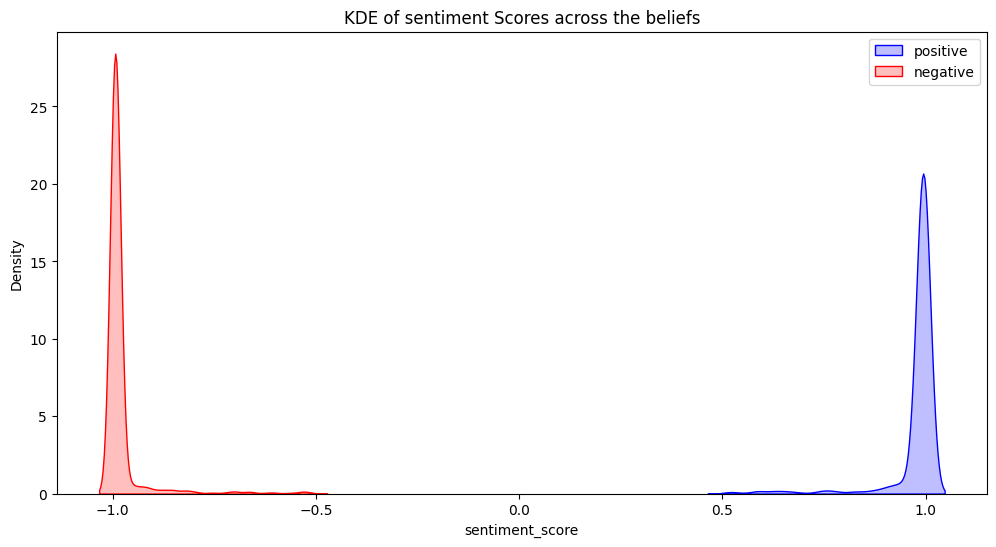

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(filtered_data[filtered_data['sentiment']=='positive']['sentiment_score'], shade=True, color="b").set_title('KDE of sentiment Scores across the beliefs')
p2=sns.kdeplot(filtered_data[filtered_data['sentiment']=='negative']['sentiment_score'], shade=True, color="r")
p3=sns.kdeplot(filtered_data[filtered_data['sentiment']=='neutral']['sentiment_score'], shade=True, color="g")
plt.legend(labels=['positive','negative','neutral'])

Removing the missing values:

## Cleaning:
We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.

In [ ]:

def preprocess_and_filter_sentences(df, text_column):
    # Assuming 'text_column' is the column in your DataFrame containing the text sentences
    sentences = df[text_column].tolist()

    # Step 1: Preprocess the text data (example using lowercase conversion)
    sentences = [sentence.lower() for sentence in sentences]

    # Step 2: Tokenize the sentences
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

    # Step 3: Filter out stop words and unwanted expressions
    stop_words = set(stopwords.words('english'))
    unwanted_words = ["'", '[ ]', '#', ' `` ', "''", '&', 'of', 'in', 'because', ',', 'say', 'and', 'on', 'the', '.', '',"",
                      ')', '(', 'ghana', 'ghanaians', 'by', 'a', '!', '“”', '<>', 'b', '/b', ' ’', 'mr', 'dr.',
                      'said', '[]', 'ii', "''", "’", "'",'\'','it’s','et al']  # Add any other unwanted words or expressions

    filtered_sentences = []

    for sentence in tokenized_sentences:
        filtered_sentence = [word for word in sentence if word not in stop_words and word not in unwanted_words]
        filtered_sentences.append(' '.join(filtered_sentence))

    # Create a new column with the filtered sentences
    df['filtered_' + text_column] = filtered_sentences

    return df

def clean_text(text, exclude_words):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

exclude_words = ['ghana', 'ghanas', 'ghanaian','ghana', 'ghanas','dr','mr','s','ii','“','”', ' ” ']  # Add the words you want to exclude



In [ ]:
filtered_data.columns

Index(['ID', 'belief', 'belief_model_confidence', 'sentence', 'location',
       'sentence_resolved', 'year', 'context', 'sentiment_score', 'PERSON',
       'ORG', 'GOVERNMENT', 'TRADITIONAL_LEADERS', 'LOCATION_',
       'ASSOCIATED_WORDS', 'Increase', 'Decrease', 'Mining', 'geometry',
       'sentiment'],
      dtype='object')

In [ ]:
# Assuming you have a DataFrame named 'extracted' with columns 'belief_resolved' and 'context'
filtered_data = preprocess_and_filter_sentences(filtered_data, 'sentence_resolved')
filtered_data = preprocess_and_filter_sentences(filtered_data, 'context')
filtered_data['filtered_sentence_resolved'] = filtered_data['filtered_sentence_resolved'].apply(lambda x:clean_text(x, exclude_words=exclude_words))
filtered_data['filtered_context'] = filtered_data['filtered_context'].apply(lambda x:clean_text(x, exclude_words=exclude_words))

#extracted['belief_resolved'] = extracted['belief_resolved'].apply(lambda x: clean_text(x, exclude_words=exclude_words))

In [ ]:
filtered_data.head(2)

,ID,belief,belief_model_confidence,sentence,location,sentence_resolved,year,context,sentiment_score,PERSON,...,TRADITIONAL_LEADERS,LOCATION_,ASSOCIATED_WORDS,Increase,Decrease,Mining,geometry,sentiment,filtered_sentence_resolved,filtered_context
25,1,True,0.997638,She said she was highly impressed and excited ...,Bui,She said she was highly impressed and excited ...,2022.0,It is intrinsically linked to all 16 of the ot...,0.995371,['Angelina Lusigi'],...,[],"['the Banda District', 'the Bono Region']",[],True,False,False,POINT (-2.53804 7.86948),positive,highly impressed excited authority floating so...,intrinsically linked goals agenda sustainabl...
30,2,True,0.999921,The BPA had also installed battery power banks...,Ankobra,The BPA had also installed battery power banks...,2022.0,She said she was highly impressed and excited ...,0.853818,['Togobo'],...,[],[],"['mining', 'Galamsey']",True,False,True,POINT (-2.10000 5.45000),positive,bpa also installed battery power banks take ca...,highly impressed excited authority floating so...


In [ ]:
filtered_data['filtered_sentence_resolved'].iloc[10]

'praying citizens promptly report fight things may eventually affect whole country ” appealed'

In [ ]:
filtered_data['sentence_resolved'].iloc[10]

'We are praying that citizens should promptly report so that we fight some of these things which may, eventually, affect the whole country,” he appealed.'

In [ ]:
# nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# def cleaning(doc):
#     # Lemmatizes and removes stopwords
#     # doc needs to be a spacy Doc object
#     txt = [token.lemma_ for token in doc if not token.is_stop]
#     # Word2Vec uses context words to learn the vector representation of a target word,
#     # if a sentence is only one or two words long,
#     # the benefit for the training is very small
#     if len(txt) > 2:
#         return ' '.join(txt)

# #Removes non-alphabetic characters:
# brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in extracted['belief_resolved'])

# #Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:
# t = time()
# txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

# print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Put the results in a DataFrame to remove missing values and duplicates:

In [ ]:
filtered_data.columns

In [ ]:
extracted = filtered_data[['ID','belief_model_confidence', 'sentence_resolved',
       'context', 'sentiment_score', 'location', 'year', 'sentiment',
       'geometry',  'filtered_sentence_resolved', 'filtered_context']]
extracted['sentence_words_list'] = extracted['filtered_sentence_resolved'].apply(lambda x:str(x).split())
extracted['context_words_list'] = extracted['filtered_context'].apply(lambda x:str(x).split())

In [ ]:
extracted.head(2)

,ID,belief_model_confidence,sentence_resolved,context,sentiment_score,location,year,sentiment,geometry,filtered_sentence_resolved,filtered_context,sentence_words_list,context_words_list
25,1,0.997638,She said she was highly impressed and excited ...,It is intrinsically linked to all 16 of the ot...,0.995371,Bui,2022.0,positive,POINT (-2.53804 7.86948),highly impressed excited authority floating so...,intrinsically linked goals agenda sustainabl...,"[highly, impressed, excited, authority, floati...","[intrinsically, linked, goals, agenda, sustain..."
30,2,0.999921,The BPA had also installed battery power banks...,She said she was highly impressed and excited ...,0.853818,Ankobra,2022.0,positive,POINT (-2.10000 5.45000),bpa also installed battery power banks take ca...,highly impressed excited authority floating so...,"[bpa, also, installed, battery, power, banks, ...","[highly, impressed, excited, authority, floati..."


cleaning locations

In [ ]:
# Remove leading and trailing spaces from the column
extracted['location'] = extracted['location'].str.strip()

In [ ]:
len(extracted.location.unique())

332

In [ ]:
# Extract rows where 'location' column contains the word 'China'
china_rows = extracted[extracted['location'].str.contains('Western')]
china_rows.location.unique()

array(['Western', 'Western North'], dtype=object)

In [ ]:
def correct_words(dataframe, column_name, old_words, new_words):
    # Iterate through the list of old words and new words
    for old_word, new_word in zip(old_words, new_words):
        # Replace the old word with the new word in the specified column
        dataframe[column_name] = dataframe[column_name].str.replace(old_word, new_word)

    return dataframe

# Example usage:
#extracted = correct_words(extracted, 'location',[ 'Ashanti '], ['Ashanti'])
extracted = correct_words(extracted,'location',['Sefwi-Wiawso', 'Wiawso'],['Wiawso', 'Wiawso'])

In [ ]:
extracted.location.value_counts()

Ghana          1146
Ashanti         236
Accra           212
Eastern         185
Western         184
               ... 
Enchi             1
Nkwantanum        1
Hemang            1
White Volta       1
Akrofufu          1
Name: location, Length: 332, dtype: int64

In [ ]:
extracted.columns

In [ ]:
# # Convert 'geometry' column to a GeoSeries
data_to_save = gpd.GeoDataFrame(extracted, geometry='geometry')

In [ ]:
data_to_save.head()

,ID,belief_model_confidence,sentence_resolved,context,sentiment_score,location,year,sentiment,geometry,filtered_sentence_resolved,filtered_context,sentence_words_list,context_words_list
25,1,0.997638,She said she was highly impressed and excited ...,It is intrinsically linked to all 16 of the ot...,0.995371,Bui,2022.0,positive,POINT (-2.53804 7.86948),highly impressed excited authority floating so...,intrinsically linked goals agenda sustainabl...,"[highly, impressed, excited, authority, floati...","[intrinsically, linked, goals, agenda, sustain..."
30,2,0.999921,The BPA had also installed battery power banks...,She said she was highly impressed and excited ...,0.853818,Ankobra,2022.0,positive,POINT (-2.10000 5.45000),bpa also installed battery power banks take ca...,highly impressed excited authority floating so...,"[bpa, also, installed, battery, power, banks, ...","[highly, impressed, excited, authority, floati..."
31,2,0.999921,The BPA had also installed battery power banks...,She said she was highly impressed and excited ...,0.853818,Pra,2022.0,positive,POINT (-1.60287 6.79029),bpa also installed battery power banks take ca...,highly impressed excited authority floating so...,"[bpa, also, installed, battery, power, banks, ...","[highly, impressed, excited, authority, floati..."
32,3,0.999926,He said the BPA was also undertaking feasibili...,"Dr Wisdom Ahaitaku Togobo, the Director of Ren...",-0.993724,Ankobra,2022.0,negative,POINT (-2.10000 5.45000),bpa also undertaking feasibility studies enabl...,dr wisdom ahaitaku togobo director renewable e...,"[bpa, also, undertaking, feasibility, studies,...","[dr, wisdom, ahaitaku, togobo, director, renew..."
33,3,0.999926,He said the BPA was also undertaking feasibili...,"Dr Wisdom Ahaitaku Togobo, the Director of Ren...",-0.993724,Pra,2022.0,negative,POINT (-1.60287 6.79029),bpa also undertaking feasibility studies enabl...,dr wisdom ahaitaku togobo director renewable e...,"[bpa, also, undertaking, feasibility, studies,...","[dr, wisdom, ahaitaku, togobo, director, renew..."


In [ ]:
output_file = '/content/drive/MyDrive/HEURISTICS/Ghana_predictions/Beliefs/ghana_beliefs/updated_extracted_data.geojson'
#data_to_save.to_file(output_file)

In [ ]:
extracted.context_words_list.iloc[1000]

['minister',
 'information',
 'mr',
 'kojo',
 'oppongnkrumah',
 'kon',
 'denied',
 'ever',
 'assembling',
 'journalists',
 'dodowa',
 'greater',
 'accra',
 'region',
 'plot',
 'bring',
 'former',
 'minister',
 'environment',
 'science',
 'technology',
 'prof',
 'frimpong',
 'boateng',
 'fight',
 'illegal',
 'mining',
 'galamsey',
 'speaking',
 'telephone',
 'interview',
 'chronicle',
 'yesterday',
 'mr',
 'oppongnkrumah',
 'indeed',
 'attended',
 'meeting',
 'forest',
 'hotel',
 'dodowa',
 'mentioned',
 'former',
 'minister',
 'invitation',
 'private',
 'newspapers',
 'publishers',
 'association',
 'pringpag',
 'holding',
 'workshop',
 'place',
 'according',
 'workshop',
 'jointly',
 'organised',
 'prinpag',
 'bank',
 'financial',
 'reporting']

In [ ]:
# Assuming 'combined_extracted_v2' is your DataFrame and 'words_list' is the column containing the lists of words
exclude_words = ['ghana', 'region','ghanas', 'ghanaian','dr','mr','s','ii', 's', 'et','al', '“','”']  # Add the words you want to exclude from the count
words = [item for sublist in extracted['sentence_words_list'] for item in sublist if item not in exclude_words]
top = Counter(words)
all_words =pd.DataFrame(top.most_common(3439))
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')


,Common_words,count
0,mining,1148
1,illegal,1003
2,galamsey,785
3,government,686
4,president,644
5,water,612
6,country,523
7,minister,416
8,also,394
9,miners,370


In [ ]:
extracted.columns

Index(['ID', 'belief_model_confidence', 'sentence_resolved', 'context',
       'sentiment_score', 'location', 'year', 'sentiment', 'geometry',
       'filtered_sentence_resolved', 'filtered_context', 'sentence_words_list',
       'context_words_list'],
      dtype='object')

In [ ]:
# Assuming 'combined_extracted_v2' is your DataFrame and 'words_list' is the column containing the lists of words
exclude_words = ['ghana', 'ghanas', 'ghanaian','dr','mr','s','ii', 's', 'et','al', '“','”']  # Add the words you want to exclude from the count
words = [item for sublist in extracted['sentence_words_list'] for item in sublist if item not in exclude_words]
top = Counter(words)
all_words =pd.DataFrame(top.most_common(3439))
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')


,Common_words,count
0,mining,1148
1,illegal,1003
2,galamsey,785
3,government,686
4,president,644
5,water,612
6,region,528
7,country,523
8,minister,416
9,also,394


In [ ]:
len(top)

8533

In [ ]:
all_words.columns = ['word','count']

## Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
https://radimrehurek.com/gensim/models/phrases.html

In [ ]:
#As `Phrases()` takes a list of list of words as input:

#sent = [row.split() for row in combined_extracted_v2['clean_beliefs']]

#Creates the relevant phrases from the list of sentences:
phrases = Phrases(extracted.sentence_words_list , min_count=30, progress_per=10000)
#phrases = Phrases(words, min_count=30, progress_per=10000)

#The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:
bigram = Phraser(phrases)

#Transform the corpus based on the bigrams detected:
sentences = bigram[extracted.sentence_words_list]

In [ ]:
sentences

## Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
      word_freq[i] += 1
len(word_freq)

8588

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:30]

['galamsey',
 'government',
 '”',
 'mining',
 'country',
 '“',
 'illegal_mining',
 'also',
 'president',
 'water',
 'activities',
 'people',
 'minister',
 'would',
 'expressed',
 'illegal_miners',
 'area',
 'one',
 'chinese',
 'environment',
 'water_bodies',
 'region',
 'menace',
 'district',
 'national',
 'fight',
 'gold',
 'expected',
 'take',
 'security']

In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in the selected beliefs', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
# Assuming 'combined_extracted_v2' is your DataFrame and 'words_list' is the column containing the lists of words
#exclude_words = ['ghana', 'ghanas', 'ghanaian', 'dr', 'mr', 's', 'ii']  # Add the words you want to exclude from the count
#extracted['words_list'] = [[word for word in sublist if word not in exclude_words] for sublist in extracted['words_list']]
Positive_sent = extracted[extracted['sentiment']=='positive']
Negative_sent = extracted[extracted['sentiment']=='negative']
Neutral_sent = extracted[extracted['sentiment']=='neutral']

In [ ]:
Positive_sent.shape,Negative_sent.shape

((981, 13), (1744, 13))

In [ ]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['sentence_words_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,mining,237
1,government,198
2,”,195
3,president,179
4,illegal,171
5,minister,158
6,country,154
7,water,152
8,galamsey,145
9,“,145


In [ ]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['sentence_words_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(30))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,illegal,562
2,galamsey,453
3,water,344
4,government,282
5,”,282
6,region,274
7,president,273
8,activities,235
9,miners,225
10,country,223


In [ ]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=500,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()
#d = '/kaggle/input/masks-for-wordclouds/'

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12, 8), color='white',
                   title=None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                          stopwords=stopwords,
                          max_words=max_words,
                          max_font_size=max_font_size,
                          random_state=42,
                          width=800,
                          height=600,
                          mask=mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                   'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                   'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()


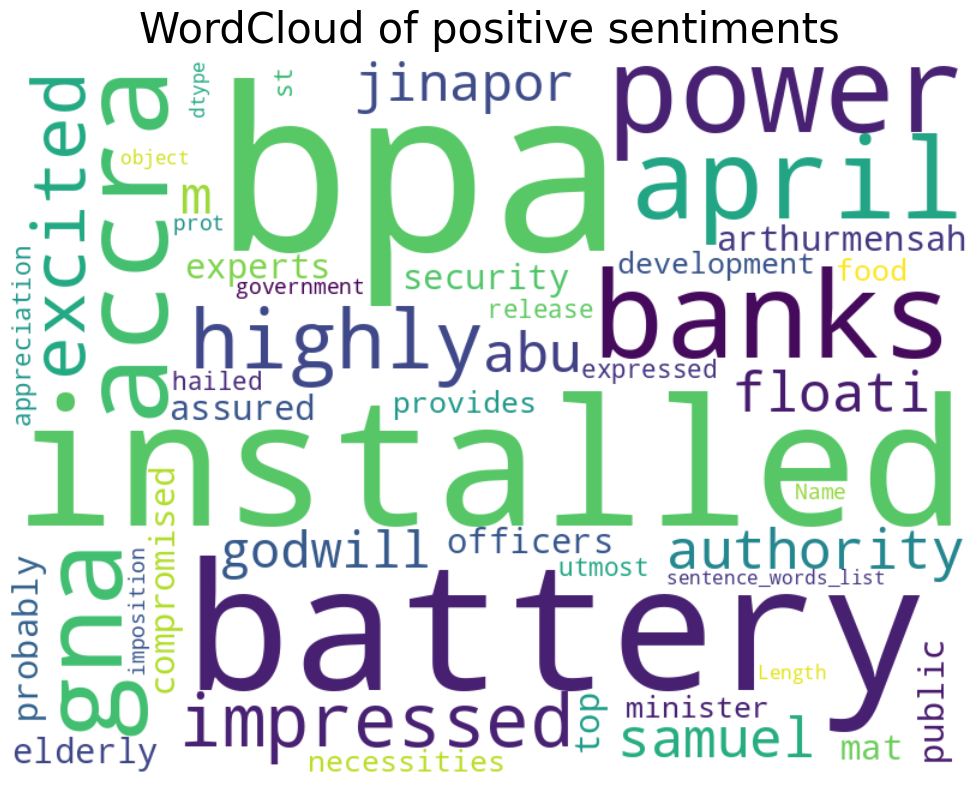

In [ ]:

plot_wordcloud(Positive_sent.sentence_words_list,mask=None,color='white',max_font_size=190,title_size=30,title="WordCloud of positive sentiments")

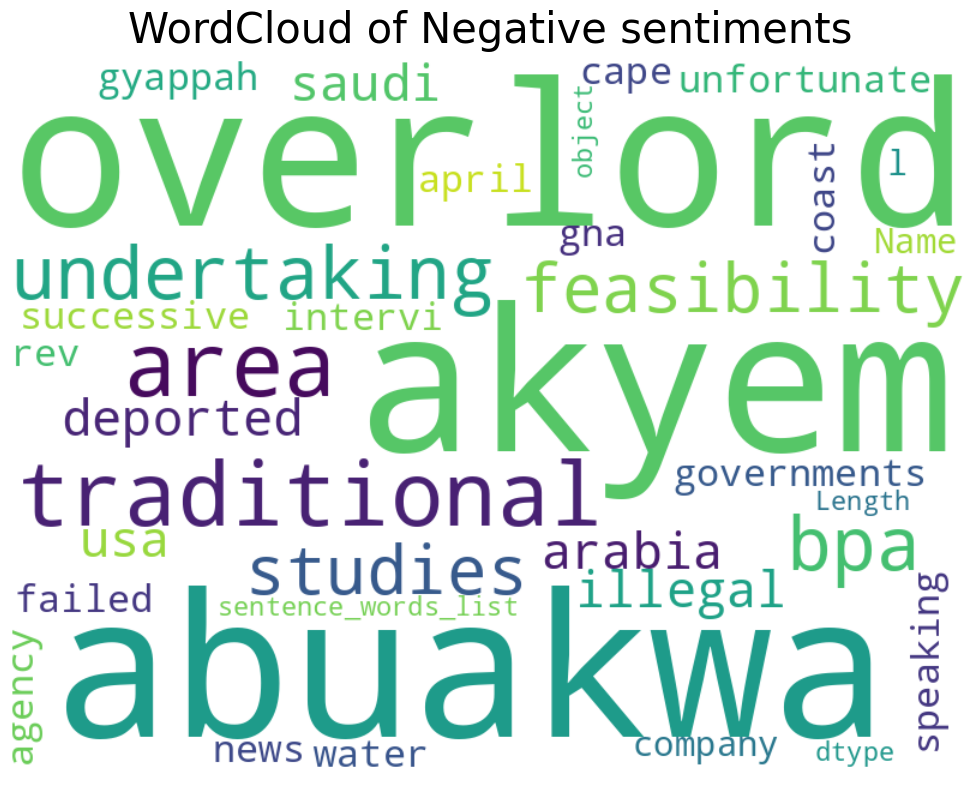

In [ ]:

plot_wordcloud(Negative_sent.sentence_words_list,mask=None,color='white',max_font_size=190,title_size=30,title="WordCloud of Negative sentiments")


# Training the model
## Gensim Word2Vec Implementation:
We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
import multiprocessing

from gensim.models import Word2Vec

## Why I seperate the training of the model in 3 steps:
I prefer to separate the training in 3 distinctive steps for clarity and monitoring.
1. `Word2Vec()`:
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`:
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. I noticed that these two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [ ]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     vector_size=600,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=10,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [ ]:
sentences

In [ ]:
t = time()

w2v_model.build_vocab(list(sentences), progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [ ]:
t = time()

w2v_model.train(list(sentences), total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.06 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [ ]:
w2v_model.init_sims()

# Exploring the model
## Most similar to:

Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

In [ ]:
w2v_model.wv.most_similar(negative='mining')

[('cutting', -0.9881107807159424),
 ('suame', -0.988964855670929),
 ('sod', -0.9890028238296509),
 ('enough', -0.9912802577018738),
 ('water', -0.9918962717056274),
 ('cecilia', -0.9929840564727783),
 ('abena', -0.9931269884109497),
 ('dapaah', -0.9932066202163696),
 ('ceremony', -0.9932397603988647),
 ('sanitation', -0.9933756589889526)]

In [ ]:
w2v_model.wv.most_similar(positive=["mining"])

[('small_scale', 0.9995192885398865),
 ('illegal', 0.9995182156562805),
 ('government', 0.9995158910751343),
 ('responsible', 0.999501645565033),
 ('ban', 0.9994990825653076),
 ('ensure', 0.9994602799415588),
 ('fight_illegal', 0.9994529485702515),
 ('engaging', 0.9994432330131531),
 ('engaged', 0.9994316101074219),
 ('gold', 0.9994171857833862)]

_A small precision here:_<br>


Let's see what the bigram "mining" gives us by comparison:

In [ ]:

w2v_model.wv.most_similar(positive=["illegal"])

[('practice', 0.9996804594993591),
 ('small_scale', 0.9996584057807922),
 ('activity', 0.9996545910835266),
 ('persons', 0.9996500015258789),
 ('near', 0.9996467232704163),
 ('miners', 0.9996426701545715),
 ('several', 0.9996397495269775),
 ('equipment', 0.9996373653411865),
 ('move', 0.999636173248291),
 ('believed', 0.9996285438537598)]

In [ ]:
w2v_model.wv.most_similar(positive=["government"])

[('efforts', 0.9997072219848633),
 ('fight', 0.9996779561042786),
 ('fight_illegal', 0.9996613264083862),
 ('engaging', 0.9996601343154907),
 ('laws', 0.9996533393859863),
 ('agencies', 0.9996418356895447),
 ('popularly_known', 0.9996415972709656),
 ('support', 0.9996375441551208),
 ('hence', 0.9996375441551208),
 ('ban', 0.9996349811553955)]

In [ ]:
w2v_model.wv.most_similar(positive=["political"])

[('current', 0.9997477531433105),
 ('position', 0.9997466802597046),
 ('believe', 0.9997434616088867),
 ('right', 0.9997402429580688),
 ('never', 0.9997401833534241),
 ('kwame', 0.9997394680976868),
 ('commitment', 0.9997384548187256),
 ('restore', 0.999736487865448),
 ('gyamfi', 0.9997355937957764),
 ('back', 0.9997342228889465)]

## Similarities:
Here, we will see how similar are two words to each other :

In [ ]:
w2v_model.wv.similarity("mining", 'water')

0.9918962

In [ ]:
w2v_model.wv.similarity('illegal', 'smallscale')

0.9995572

In [ ]:
w2v_model.wv.doesnt_match(['smallscale', 'water', 'resource'])

'smallscale'

In [ ]:
w2v_model.wv.doesnt_match(["illegal", "mining", "authority"])

'authority'

In [ ]:
w2v_model.wv.doesnt_match(['mining', 'authority', 'responsibility'])

'mining'

Damn, they really do not like you mining!

## Analogy difference:
Which word is to woman as mining is to marge?

In [ ]:
w2v_model.wv.most_similar(positive=["national", "mining"], negative=["illegal"], topn=3)

[('fight_illegal', 0.9991601705551147),
 ('ensure', 0.9991003274917603),
 ('small_scale', 0.9990962743759155)]

"man" comes at the first position, that looks about right!

Which word is to woman as bart is to man?

In [ ]:
w2v_model.wv.most_similar(positive=["illegal", "water"], negative=["region"], topn=3)

[('dapaah', 0.9985138177871704),
 ('sanitation', 0.9984723329544067),
 ('cecilia', 0.9984706044197083)]

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import nltk

nltk.download('stopwords')

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.<br>
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 600), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=16).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    extracted = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=extracted,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': extracted['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, extracted.shape[0]):
         p1.text(extracted["x"][line],
                 extracted['y'][line],
                 '  ' + extracted["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=extracted['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-30, Y[:, 0].max()+30)
    plt.ylim(Y[:, 1].min()-30, Y[:, 1].max()+30)

    plt.title('t-SNE visualization for {}'.format(word.title()))


Code inspired by: [[2]](#References:)

## 10 Most similar words vs. 8 Random words:
Let's compare where the vector representation of mining, his 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph:

In [ ]:
# query_words = ['illegal_mining', 'mining', 'activity']  # List of query words
# list_words = ['region','galamsey','express','country','say','state', 'water', 'environment']  # List of words to include in the plot
# tsnescatterplot(w2v_model, query_words, list_words)


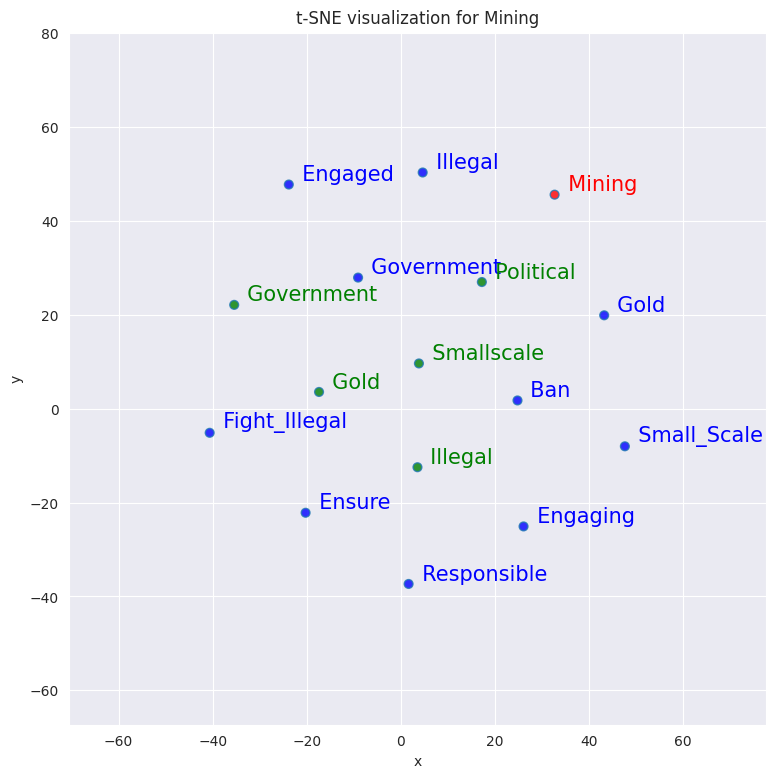

In [ ]:
tsnescatterplot(w2v_model, 'mining', ['political','government', 'smallscale', 'gold','illegal' ])

Interestingly, the 10 most similar words to mining ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

## 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of mining and its 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to mining:

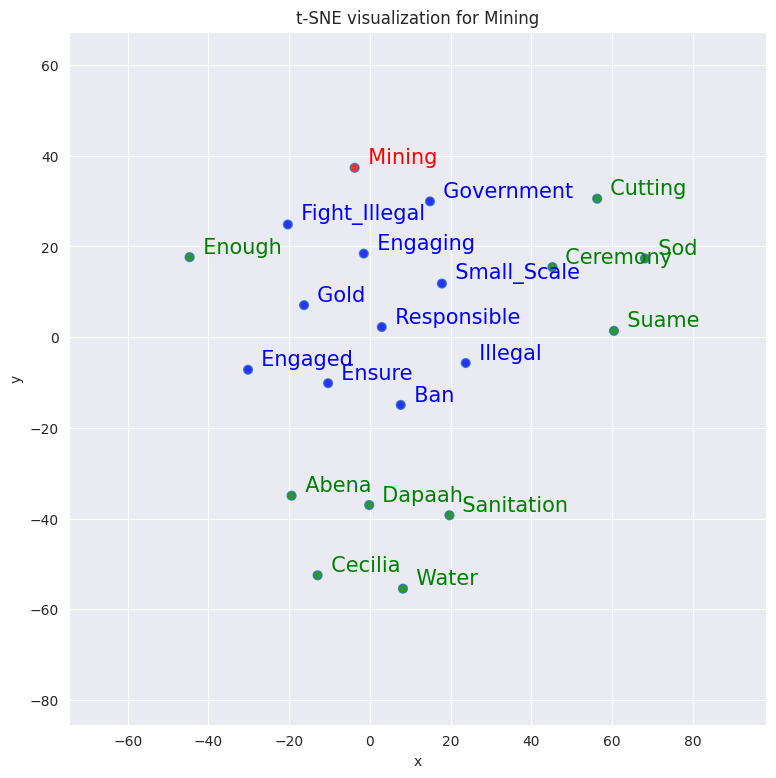

In [ ]:
tsnescatterplot(w2v_model, 'mining', [i[0] for i in w2v_model.wv.most_similar(negative=["mining"])])

Neat! Mining and its most similar words form a distinctive cluster from the most dissimilar words, it is a really encouraging plot!

## 10 Most similar words vs. 11th to 20th Most similar words:

Finally, we are going to plot the most similar words to water ranked 1st to 10th versus the ones ranked 11th to 20th:



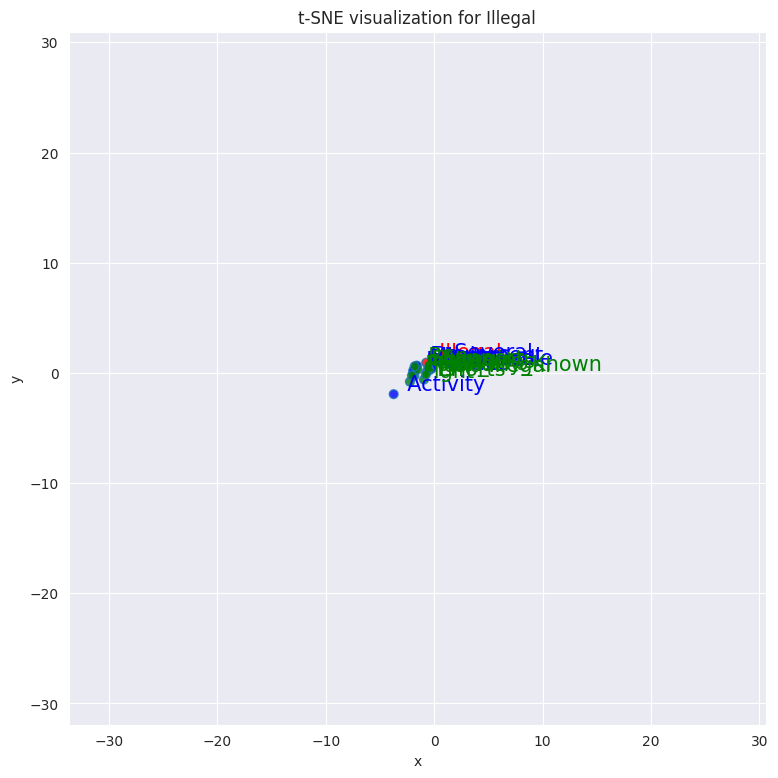

In [ ]:
tsnescatterplot(w2v_model, "illegal", [t[0] for t in w2v_model.wv.most_similar(positive=["government"], topn=10)])

In [ ]:
model = w2v_model

In [ ]:

# # Get the word embeddings
# word_embeddings = w2v_model.wv

# # Calculate polarity of all words
# polarity_scores = {}
# target_word = 'illegal'  # The word you want to compare with other words in the sentences

# for sentence in extracted.clean_beliefs:
#     for word in sentence:
#         if word not in polarity_scores:
#             similarity_score = model.wv.similarity(target_word, word)
#             polarity_scores[word] = similarity_score

# # Convert word embeddings and polarity scores to arrays
# word_vectors = np.array([word_embeddings[word] for word in polarity_scores])
# polarity_values = np.array(list(polarity_scores.values())).reshape(-1, 1)

# # Perform t-SNE dimensionality reduction
# tsne = TSNE(n_components=2, random_state=42)
# word_vectors_tsne = tsne.fit_transform(word_vectors)

# # Cluster the word vectors
# num_clusters = 6  # Adjust the number of clusters as desired
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# clusters = kmeans.fit_predict(word_vectors_tsne)

# # Plot the clusters
# plt.figure(figsize=(10, 6))
# for i in range(num_clusters):
#     cluster_words = np.array(list(polarity_scores.keys()))[clusters == i]
#     y = polarity_values[clusters == i]
#     x = np.ones_like(y) * i
#     plt.scatter(x, y, label=f'Cluster {i + 1}')

# plt.xlabel('Cluster')
# plt.ylabel('Polarity Score')
# plt.title('Word Clusters based on Polarity')
# plt.legend()
# plt.show()

In the provided code, the polarity score is calculated for each word in the 'words_list' column using VADER (Valence Aware Dictionary and sEntiment Reasoner). The `calculate_polarity_score()` function applies the VADER sentiment analyzer to each word and retrieves the compound polarity score, which represents the overall sentiment intensity of the word.

However, it's important to note that the code snippet you provided calculates the polarity scores for individual words within each row, not across all rows. The lambda function inside the `apply()` method applies the `calculate_polarity_score()` function to each word in the 'words_list' column using a list comprehension.

So, for each row, the 'polarity_scores' column will contain a list of polarity scores, where each score corresponds to the sentiment intensity of a word in the 'words_list' for that specific row.

If you want to calculate the polarity scores for each belief sentence as a whole, you should modify the code to calculate the scores for the belief sentence instead of individual words within the 'words_list' column. Here's an updated code snippet:


In this updated code, the `calculate_polarity_score()` function takes the belief sentence as input and calculates the polarity score for the entire sentence using VADER. The polarity score is assigned to the corresponding row in the 'polarity_scores' column.

Please note that this code assumes you have the 'belief_resolved' column containing the belief sentences. Adjust the column names and DataFrame structure accordingly based on your specific data.

In [ ]:
extracted.columns

Index(['ID', 'belief_model_confidence', 'sentence_resolved', 'context',
       'sentiment_score', 'location', 'year', 'sentiment', 'geometry',
       'filtered_sentence_resolved', 'filtered_context', 'sentence_words_list',
       'context_words_list'],
      dtype='object')

In [ ]:
# Define the words you want to exclude
exclude_words = ['ghana', 'ghanas', 'ghanaian','dr','mr','s','ii', 's', 'et','al', '“','”']

# Function to filter out words
def exclude_words_from_list(word_list):
    filtered_words = [word for word in word_list if word not in exclude_words]
    return filtered_words

# Apply the function to the column
extracted['sentence_words_list'] = extracted['sentence_words_list'].apply(lambda x: exclude_words_from_list(x))

In [ ]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate the polarity score for a sentence using VADER
def calculate_polarity_score(sentence):
    sentiment_scores = sia.polarity_scores(sentence)
    polarity_score = sentiment_scores['compound']
    return polarity_score

# Apply the polarity score calculation to the 'words_list' column
extracted['polarity_scores'] = extracted['sentence_words_list'].apply(lambda words: [calculate_polarity_score(word) for word in words])


In [ ]:
#extracted.to_file('/content/drive/MyDrive/HEURISTICS/Ghana_predictions/Beliefs/ghana_beliefs/final_data.geojson', driver ='GeoJSON')
#extracted.to_file('/content/drive/MyDrive/HEURISTICS/Ghana_predictions/Beliefs/ghana_beliefs.final_data.shp', driver='ESRI Shapefile')


In [ ]:
extracted.sentence_words_list.tail(5)

28597    [overlord, akyem, abuakwa, traditional, area, ...
28621    [also, deported, usa, saudi, arabia, illegal, ...
28622    [also, deported, usa, saudi, arabia, illegal, ...
28632    [minister, lands, natural, resources, samuel, ...
28636    [accident, thought, occurred, others, arrived,...
Name: sentence_words_list, dtype: object

In [ ]:
extracted['polarity_scores'].min()

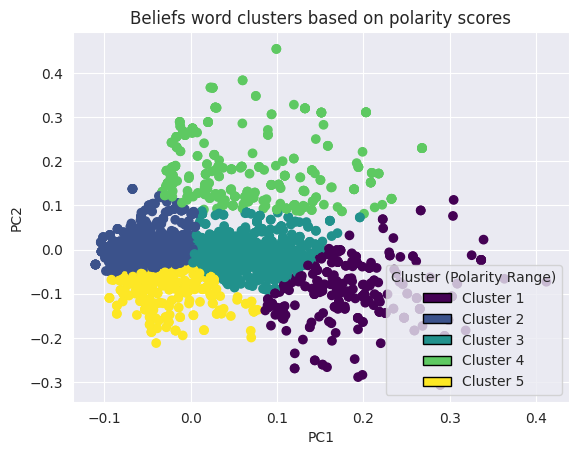

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.cm import get_cmap

# Prepare the data
words_list = extracted['sentence_words_list'].tolist()
polarity_scores = extracted['polarity_scores'].tolist()

# Convert words_list to text corpus
corpus = [' '.join(words) for words in words_list]

# Create TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Apply dimensionality reduction
pca = PCA(n_components=2)
embeddings = pca.fit_transform(tfidf_matrix.toarray())

# Apply clustering algorithm
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(embeddings)

# Determine the minimum and maximum polarity scores for each cluster
cluster_polarity = []
for cluster in range(num_clusters):
    polarity_values = [polarity_scores[i] for i in range(len(clusters)) if clusters[i] == cluster]
    cluster_polarity.append((min(polarity_values), max(polarity_values)))

# Create a custom colormap for clusters
cmap = get_cmap('viridis', num_clusters)

# Create legend elements for clusters with polarity score ranges
legend_elements = []
for cluster in range(num_clusters):
    legend_elements.append(Patch(facecolor=cmap(cluster), edgecolor='black', label=f'Cluster {cluster+1}'))

# Visualize the clusters
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Beliefs word clusters based on polarity scores')
plt.legend(handles=legend_elements, loc='lower right', title='Cluster (Polarity Range)')
plt.show()




In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.cm import get_cmap

# Prepare the data
words_list = extracted['sentence_words_list'].tolist()
polarity_scores = extracted['polarity_scores'].tolist()

# Convert words_list to text corpus
corpus = [' '.join(words) for words in words_list]

# Create TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Apply dimensionality reduction
pca = PCA(n_components=2)
embeddings = pca.fit_transform(tfidf_matrix.toarray())

# Apply clustering algorithm
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(embeddings)

# Determine the minimum and maximum polarity scores for each cluster
cluster_polarity = []
for cluster in range(num_clusters):
    polarity_values = [polarity_scores[i] for i in range(len(clusters)) if clusters[i] == cluster]
    cluster_polarity.append((min(polarity_values), max(polarity_values)))

# Create a custom colormap for clusters
cmap = get_cmap('viridis', num_clusters)

# Create legend elements for clusters with polarity score ranges
legend_elements = []
for cluster in range(num_clusters):
    legend_elements.append(Patch(facecolor=cmap(cluster), edgecolor='black',
                                label=f'Cluster {cluster+1} ({cluster_polarity[cluster][0]:.2f}-{cluster_polarity[cluster][1]:.2f})'))

# Visualize the clusters
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Beliefs word clusters based on polarity scores')
plt.legend(handles=legend_elements, loc='lower right', title='Cluster (Polarity Range)')
plt.show()


TypeError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap

# Prepare the data
words_list = extracted['sentence_words_list'].tolist()
polarity_scores = extracted['polarity_scores'].tolist()

# Convert words_list to text corpus
corpus = [' '.join(words) for words in words_list]

# Create TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Apply dimensionality reduction
pca = PCA(n_components=2)
embeddings = pca.fit_transform(tfidf_matrix.toarray())

# Apply clustering algorithm
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(embeddings)

# Calculate the minimum and maximum polarity scores for each cluster
cluster_polarity = {}
for cluster in range(num_clusters):
    cluster_polarity[cluster] = (min(polarity_scores[i] for i, c in enumerate(clusters) if c == cluster),
                                max(polarity_scores[i] for i, c in enumerate(clusters) if c == cluster))

# Create a custom colormap for clusters
cmap = get_cmap('viridis', num_clusters)
print(cluster_polarity[cluster])
# # Create a custom legend for clusters with polarity score ranges
# legend_elements = [
#     Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=10,
#            label='Cluster %s (%.2f-%.2f)' % (cluster+1, cluster_polarity[cluster][0], cluster_polarity[cluster][1]))
#     for cluster in range(num_clusters)
# ]



# # Visualize the clusters with legend
# plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('Beliefs word clusters based on polarity scores')
# plt.legend(handles=legend_elements)
# plt.show()


2


In [ ]:
cluster

4

In [ ]:
#print(cluster_polarity[cluster][2])

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.cm import get_cmap

# Prepare the data
words_list = extracted['sentence_words_list'].tolist()
polarity_scores = extracted['polarity_scores'].tolist()

# Convert words_list to text corpus
corpus = [' '.join(words) for words in words_list]

# Create TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Apply dimensionality reduction
pca = PCA(n_components=2)
embeddings = pca.fit_transform(tfidf_matrix.toarray())

# Apply clustering algorithm
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(embeddings)

# Determine the minimum and maximum polarity scores for each cluster
cluster_polarity = []
for cluster in range(num_clusters):
    polarity_values = [polarity_scores[i] for i in range(len(clusters)) if clusters[i] == cluster]
    cluster_polarity.append((min(polarity_values), max(polarity_values)))

# Create a custom colormap for clusters
cmap = get_cmap('viridis', num_clusters)

# Create legend elements for clusters with polarity score ranges
legend_elements = [
    Patch(facecolor=cmap(cluster), edgecolor='black',
          label=f'Cluster {cluster+1} ({cluster_polarity[cluster][0]:.2f}-{cluster_polarity[cluster][1]:.2f})')
    for cluster in range(num_clusters)
]

# Visualize the clusters
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Beliefs word clusters based on polarity scores')
plt.legend(handles=legend_elements, loc='lower right', title='Cluster (Polarity Range)')
plt.show()


TypeError: ignored

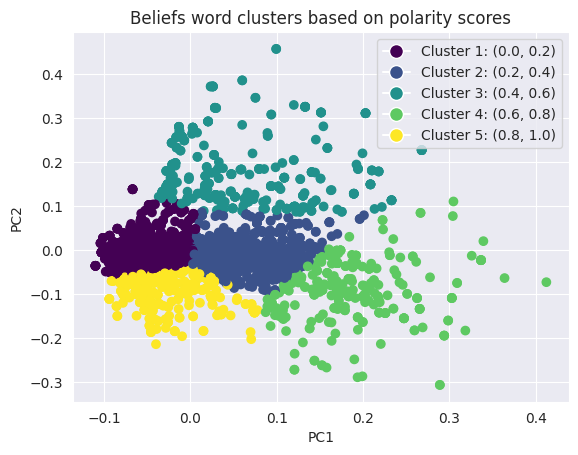

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import numpy as np

# Prepare the data
words_list = extracted['sentence_words_list'].tolist()
polarity_scores = extracted['polarity_scores'].tolist()

# Convert words_list to text corpus
corpus = [' '.join(words) for words in words_list]

# Create TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Apply dimensionality reduction
pca = PCA(n_components=2)
embeddings = pca.fit_transform(tfidf_matrix.toarray())

# Apply clustering algorithm
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(embeddings)

# Define the polarity score ranges for each cluster
polarity_score_ranges = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]

# Create a custom colormap for clusters
cmap = get_cmap('viridis', num_clusters)

# Create a custom legend for clusters with polarity score ranges as labels
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=10,
           label=f'Cluster {cluster+1}: {polarity_score_ranges[cluster]}')
    for cluster in range(num_clusters)
]

# Visualize the clusters with legend
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Beliefs word clusters based on polarity scores')
plt.legend(handles=legend_elements)
plt.show()


In [ ]:
extracted.columns

Index(['ID', 'belief_model_confidence', 'sentence_resolved', 'context',
       'sentiment_score', 'location', 'year', 'sentiment', 'geometry',
       'filtered_sentence_resolved', 'filtered_context', 'sentence_words_list',
       'context_words_list', 'polarity_scores'],
      dtype='object')

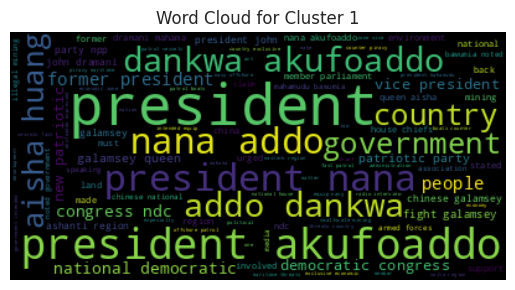

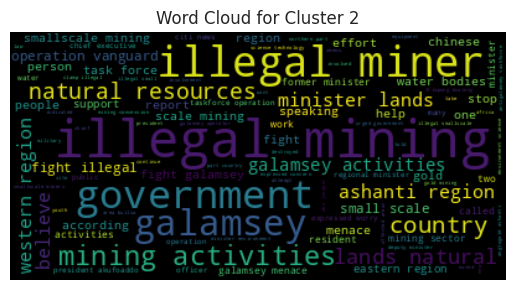

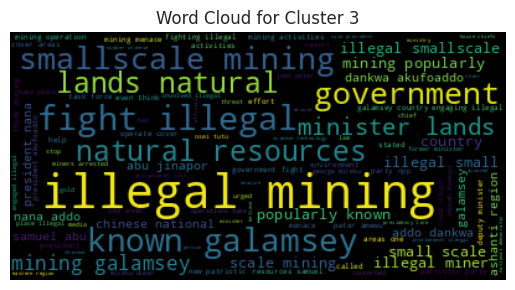

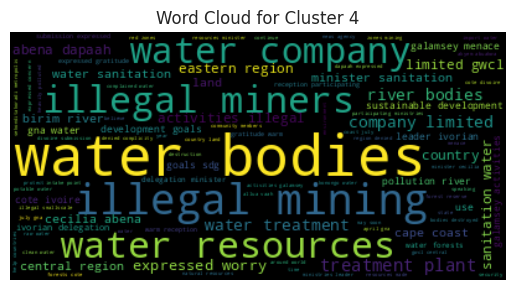

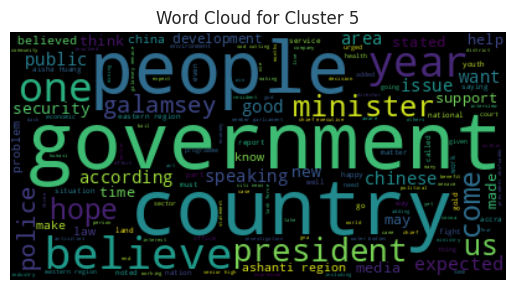

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each cluster
for cluster in range(num_clusters):
    # Get the words for the current cluster
    cluster_words = [word for i, words in enumerate(words_list) for word in words if clusters[i] == cluster]

    # Create a word cloud for the cluster words
    wordcloud = WordCloud(background_color='black').generate(' '.join(cluster_words))

    # Plot the word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster+1}')
    plt.axis('off')
    plt.show()


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each cluster
for cluster in range(num_clusters):
    # Get the words for the current cluster
    cluster_words = [word for i, words in enumerate(words_list) for word in words if clusters[i] == cluster]

    # Create a word cloud for the cluster words with black background
    wordcloud = WordCloud(background_color='black').generate(' '.join(cluster_words))

    # Plot the word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster+1}')
    plt.axis('off')

    # Save the word cloud as an image file
    filename = f'new_beliefs_wordcloud_more_cluster_{cluster+1}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    print(f'Word cloud for Cluster {cluster+1} saved as {filename}')


Word cloud for Cluster 1 saved as new_beliefs_wordcloud_more_cluster_1.png
Word cloud for Cluster 2 saved as new_beliefs_wordcloud_more_cluster_2.png
Word cloud for Cluster 3 saved as new_beliefs_wordcloud_more_cluster_3.png
Word cloud for Cluster 4 saved as new_beliefs_wordcloud_more_cluster_4.png
Word cloud for Cluster 5 saved as new_beliefs_wordcloud_more_cluster_5.png


In [ ]:
extracted.location.value_counts()

Ghana          1146
Ashanti         236
Accra           212
Eastern         185
Western         184
               ... 
Enchi             1
Nkwantanum        1
Hemang            1
White Volta       1
Akrofufu          1
Name: location, Length: 332, dtype: int64

In [ ]:
# Prepare the data
locations = extracted['location'].tolist()
polarity_scores = extracted['polarity_scores'].tolist()

# Group polarity scores by location
location_scores = {}
for location, score in zip(locations, polarity_scores):
    if location in location_scores:
        location_scores[location].append(score)
    else:
        location_scores[location] = [score]

# Filter locations with a count above 20
filtered_locations = [location for location, scores in location_scores.items() if len(scores) > 20]

# Filter locations and their corresponding polarity scores
filtered_data = [(location, score) for location, scores in location_scores.items() for score in scores if location in filtered_locations]

# Separate locations and polarity scores into separate lists
filtered_locations, filtered_scores = zip(*filtered_data)

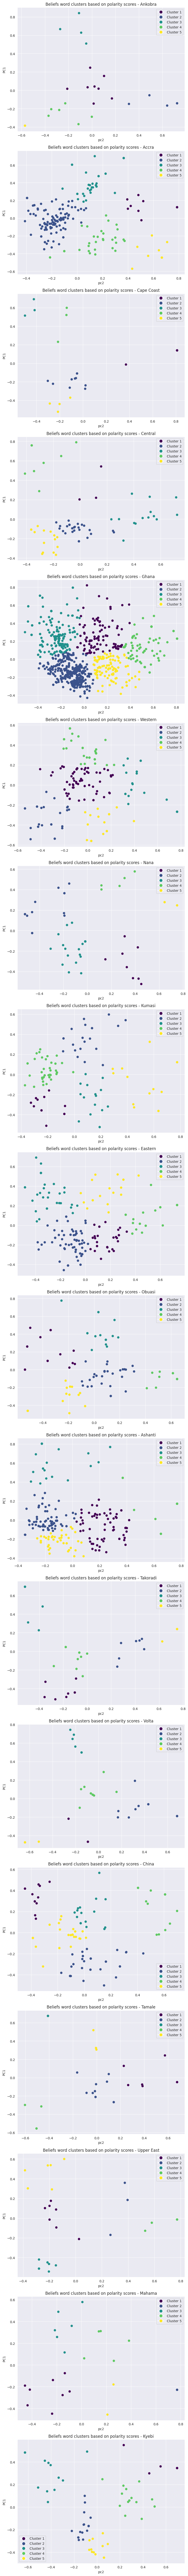

In [ ]:
# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()
#print(locations)
# Initialize figure and axes
fig, ax = plt.subplots(nrows=len(locations), figsize=(8, 6 * len(locations)))

# Iterate over the locations
for i, location in enumerate(locations):
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    geometry_coords = location_extracted['geometry'].tolist()

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-Iextracted matrix
    vectorizer = TfidfVectorizer()
    tfiextracted_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfiextracted_matrix.toarray())
    #print(embeddings)

    # Apply clustering algorithm
    num_clusters = 5  # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Create a custom colormap for clusters
    cmap = get_cmap('viridis', num_clusters)

    # Create a custom legend for clusters
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=10,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters)
    ]

    # Plot the scatter plot of the polarity scores
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
    ax[i].set_xlabel('pc2')
    ax[i].set_ylabel('PC1')
    ax[i].set_title(f'Beliefs word clusters based on polarity scores - {location}')
    ax[i].legend(handles=legend_elements)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Initialize figure and axes
fig, ax = plt.subplots(nrows=len(locations), figsize=(8, 6 * len(locations)))

# Iterate over the locations
for i, location in enumerate(locations):
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    words_list = location_extracted['sentence_words_list'].tolist()

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-Iextracted matrix
    vectorizer = TfidfVectorizer()
    tfiextracted_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfiextracted_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 3  # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Create a custom colormap for clusters
    cmap = get_cmap('viridis', num_clusters)

    # Create a custom legend for clusters
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=10,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters)
    ]

    # Plot the scatter plot of the polarity scores
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    ax[i].set_title(f'Beliefs word clusters based on polarity scores - {location}')
    ax[i].legend(handles=legend_elements)

    # Generate word cloud for each cluster
    for cluster_num in range(num_clusters):
        cluster_words = [word for words, cluster in zip(words_list, clusters) for word in words if cluster == cluster_num]
        cluster_text = ' '.join(cluster_words)
        wordcloud = WordCloud(background_color='black').generate(cluster_text)
        plt.figure(figsize=(6, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - Cluster {cluster_num+1} - {location}')
        plt.show()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


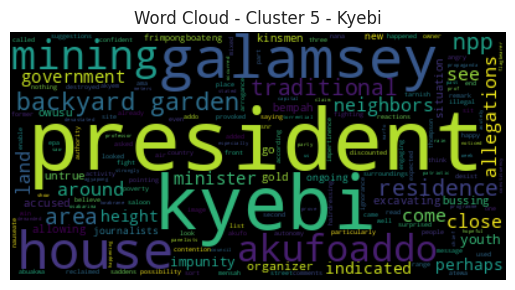

In [ ]:
# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Iterate over the locations
for location in locations:
    # Create a directory for saving the word cloud images for the current location
    save_dir = f"wordclouds/{location.replace(' ', '_')}"
    os.makedirs(save_dir, exist_ok=True)

    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    words_list = location_extracted['sentence_words_list'].tolist()

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-Iextracted matrix
    vectorizer = TfidfVectorizer()
    tfiextracted_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfiextracted_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 5 # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Generate word cloud for each cluster
    for cluster_num in range(num_clusters):
        cluster_words = [word for words, cluster in zip(words_list, clusters) for word in words if cluster == cluster_num]
        cluster_text = ' '.join(cluster_words)
        wordcloud = WordCloud(background_color='black').generate(cluster_text)

        # Save the word cloud image with title
        img_path = os.path.join(save_dir, f'cluster_{cluster_num + 1}-{location.replace(" ", "_")}_wordcloud.png')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - Cluster {cluster_num+1} - {location}')
        plt.savefig(img_path)
        #plt.close()  # Close the figure to avoid displaying the plot



In [ ]:
# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Iterate over the locations
for location in locations:
    # Create a directory for saving the word cloud images for the current location
    save_dir = f"wordclouds/{location.replace(' ', '_')}"
    os.makedirs(save_dir, exist_ok=True)

    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    words_list = location_extracted['sentence_words_list'].tolist()

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-Iextracted matrix
    vectorizer = TfidfVectorizer()
    tfiextracted_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfiextracted_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 5 # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Generate word cloud for each cluster
    for cluster_num in range(num_clusters):
        cluster_words = [word for words, cluster in zip(words_list, clusters) for word in words if cluster == cluster_num]
        cluster_text = ' '.join(cluster_words)
        wordcloud = WordCloud(background_color='black').generate(cluster_text)

        # Save the word cloud image with title
        img_path = os.path.join(save_dir, f'cluster_{cluster_num + 1}-{location.replace(" ", "_")}_wordcloud.png')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - Cluster {cluster_num+1} - {location}')
        plt.savefig(img_path)
        plt.close()  # Close the figure to avoid displaying the plot




In [ ]:
# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Iterate over the locations
for location in locations:
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    geometry_coords = location_extracted['geometry'].tolist()

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-Iextracted matrix
    vectorizer = TfidfVectorizer()
    tfiextracted_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfiextracted_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 5  # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Create a custom colormap for clusters
    cmap = get_cmap('viridis', num_clusters)

    # Create a custom legend for clusters
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=10,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters)
    ]

    # Plot the scatter plot of the polarity scores
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'Beliefs word clusters based on polarity scores - {location}')
    ax.legend(handles=legend_elements)

    # Save the plot image
    save_dir = '/content/drive/MyDrive/HEURISTICS/Ghana_predictions/Beliefs/images/'
    os.makedirs(save_dir, exist_ok=True)
    img_path = os.path.join(save_dir, f'cluster_plot_{location.replace(" ", "_")}.png')
    plt.savefig(img_path)
    plt.close()  # Close the figure to free up memory

# Show the plots
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import os

# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Initialize figure and axes
fig, ax = plt.subplots(nrows=len(locations), figsize=(10, 10 * len(locations)))

# Iterate over the locations
for i, location in enumerate(locations):
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    geometry_coords = location_extracted['geometry'].tolist()

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-Iextracted matrix
    vectorizer = TfidfVectorizer()
    tfiextracted_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfiextracted_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 5  # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Create a custom colormap for clusters
    cmap = get_cmap('viridis', num_clusters)

    # Create a custom legend for clusters
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=8,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters)
    ]

    # Plot the scatter plot of the polarity scores and annotate with highest polarity word
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    ax[i].set_title(f'Beliefs word clusters based on polarity scores - {location}')
    ax[i].legend(handles=legend_elements)

    # Annotate the scatter plot with the word having highest polarity score
    words_list = location_extracted['sentence_words_list'].tolist()
    for j, word in enumerate(words_list):
        x, y = embeddings[j, 0], embeddings[j, 1]
        highest_polarity_word = max(zip(word, polarity_scores[j]), key=lambda x: x[1])[0]
        ax[i].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Save the plot image
    save_dir = 'cluster_plots'
    os.makedirs(save_dir, exist_ok=True)
    img_path = os.path.join(save_dir, f'cluster_plot_{location.replace(" ", "_")}.png')
    plt.savefig(img_path)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import os

# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Initialize figure and axes
fig, ax = plt.subplots(nrows=len(locations), figsize=(8, 6 * len(locations)))

# Iterate over the locations
for i, location in enumerate(locations):
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    geometry_coords = location_extracted['geometry'].tolist()

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-IDF matrix
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfidf_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 5  # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Create a custom colormap for clusters
    cmap = get_cmap('viridis', num_clusters)

    # Create a custom legend for clusters
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=8,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters)
    ]

    # Plot the scatter plot of the polarity scores and annotate with highest polarity word
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    ax[i].set_title(f'Beliefs word clusters based on polarity scores - {location}')
    ax[i].legend(handles=legend_elements)

    # Annotate the scatter plot with the word having highest polarity score
    words_list = location_extracted['sentence_words_list'].tolist()
    for j, word in enumerate(words_list):
        x, y = embeddings[j, 0], embeddings[j, 1]
        highest_polarity_word = max(zip(word, polarity_scores[j]), key=lambda x: x[1])[0]
        ax[i].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Save the plot image
    #save_dir = 'cluster_plots'
    #os.makedirs(save_dir, exist_ok=True)
    #img_path = os.path.join(save_dir, f'cluster_plot_{location.replace(" ", "_")}.png')
   # plt.savefig(img_path)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import os

# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Initialize figure and axes
fig, ax = plt.subplots(nrows=len(locations), figsize=(8, 6 * len(locations)))

# Iterate over the locations
for i, location in enumerate(locations):
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    geometry_coords = location_extracted['geometry'].tolist()

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-IDF matrix
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfidf_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 5  # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Create a custom colormap for clusters
    cmap = get_cmap('viridis', num_clusters)

    # Create a custom legend for clusters
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=8,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters)
    ]

    # Plot the scatter plot of the polarity scores and annotate with highest polarity word
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    ax[i].set_title(f'Beliefs word clusters based on polarity scores - {location}')
    ax[i].legend(handles=legend_elements)

    # Annotate the scatter plot with the word having highest polarity score
    words_list = location_extracted['words_list'].tolist()
    for j, word in enumerate(words_list):
        x, y = embeddings[j, 0], embeddings[j, 1]
        highest_polarity_word = max(zip(word, polarity_scores[j]), key=lambda x: x[1])[0]
        ax[i].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Save the plot image
    save_dir = 'cluster_plots'
    os.makedirs(save_dir, exist_ok=True)
    img_path = os.path.join(save_dir, f'cluster_plot_{location.replace(" ", "_")}.png')
    plt.savefig(img_path)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import os

# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Initialize figure and axes
fig, ax = plt.subplots(nrows=len(locations), figsize=(15, 15 * len(locations)))

# Iterate over the locations
for i, location in enumerate(locations):
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    geometry_coords = location_extracted['geometry'].tolist()

    # Set the threshold value for categorizing the scores
    threshold = 0.0

    # Categorize polarity scores into positive, neutral, and negative
    positive_scores = [score[0] if score[0] > threshold else 0.0 for score in polarity_scores]
    neutral_scores = [score[0] if score[0] == threshold else 0.0 for score in polarity_scores]
    negative_scores = [score[0] if score[0] < threshold else 0.0 for score in polarity_scores]

    # Normalize the scores within the range [0, 1]
    min_score = min(score[0] for score in polarity_scores)
    max_score = max(score[0] for score in polarity_scores)
    normalized_scores = [(score[0] - min_score) / (max_score - min_score) for score in polarity_scores]

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-IDF matrix
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfidf_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 5  # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Create a custom colormap for clusters
    cmap = get_cmap('viridis', num_clusters)

    # Create a custom legend for clusters
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=8,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters)
    ]

    # Plot the scatter plot of the polarity scores and annotate with the highest polarity word
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=normalized_scores, cmap=cmap)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    ax[i].set_title(f'Beliefs word clusters based on polarity scores - {location}')
    ax[i].legend(handles=legend_elements)

    # Annotate the scatter plot with the word having the highest polarity score
    words_list = location_extracted['words_list'].tolist()
    for j, word in enumerate(words_list):
        x, y = embeddings[j, 0], embeddings[j, 1]
        #highest_polarity_word = max(zip(word, polarity_scores[j]), key=lambda x: x[1][0])[0]
        highest_polarity_word = max(zip(word, polarity_scores), key=lambda x: x[1][0])[0]

        ax[i].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Save the plot image
    save_dir = 'cluster_plots'
    os.makedirs(save_dir, exist_ok=True)
    img_path = os.path.join(save_dir, f'cluster_plot_{location.replace(" ", "_")}.png')
    plt.savefig(img_path)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import os

# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Initialize figure and axes
fig, ax = plt.subplots(nrows=len(locations), figsize=(8, 6 * len(locations)))

# Iterate over the locations
for i, location in enumerate(locations):
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    geometry_coords = location_extracted['geometry'].tolist()

    # Categorize polarity scores into positive, neutral, and negative
    # Categorize polarity scores into positive, neutral, and negative
    positive_scores = [max(score) if max(score) > 0.0 else 0.0 for score in polarity_scores]
    negative_scores = [-min(score) if min(score) < 0.0 else 0.0 for score in polarity_scores]


    # Convert polarity scores to text corpus
    corpus_positive = [' '.join(map(str, [score])) for score in positive_scores]
    corpus_negative = [' '.join(map(str, [score])) for score in negative_scores]

    # Create TF-IDF matrix for positive scores
    vectorizer_positive = TfidfVectorizer()
    tfidf_matrix_positive = vectorizer_positive.fit_transform(corpus_positive)

    # Create TF-IDF matrix for negative scores
    vectorizer_negative = TfidfVectorizer()
    tfidf_matrix_negative = vectorizer_negative.fit_transform(corpus_negative)

    # Apply dimensionality reduction for positive scores
    pca_positive = PCA(n_components=2)
    embeddings_positive = pca_positive.fit_transform(tfidf_matrix_positive.toarray())

    # Apply dimensionality reduction for negative scores
    pca_negative = PCA(n_components=2)
    embeddings_negative = pca_negative.fit_transform(tfidf_matrix_negative.toarray())

    # Apply clustering algorithm for positive scores
    num_clusters_positive = 5  # Specify the number of clusters for positive scores
    kmeans_positive = KMeans(n_clusters=num_clusters_positive)
    clusters_positive = kmeans_positive.fit_predict(embeddings_positive)

    # Apply clustering algorithm for negative scores
    num_clusters_negative = 5  # Specify the number of clusters for negative scores
    kmeans_negative = KMeans(n_clusters=num_clusters_negative)
    clusters_negative = kmeans_negative.fit_predict(embeddings_negative)

    # Create a custom colormap for clusters
    cmap_positive = get_cmap('viridis', num_clusters_positive)
    cmap_negative = get_cmap('viridis', num_clusters_negative)

    # Create a custom legend for clusters
    legend_elements_positive = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_positive(cluster), markersize=8,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters_positive)
    ]

    legend_elements_negative = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_negative(cluster), markersize=8,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters_negative)
    ]

    # Plot the scatter plot of the positive polarity scores and annotate with highest polarity word
    ax[i].scatter(embeddings_positive[:, 0], embeddings_positive[:, 1], c=clusters_positive, cmap=cmap_positive)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    ax[i].set_title(f'Location: {location} (Positive Polarity Scores)')
    ax[i].legend(handles=legend_elements_positive)

    for j, word in enumerate(corpus_positive):
        x, y = embeddings_positive[j, 0], embeddings_positive[j, 1]
        #highest_polarity_word = max(zip(word.split(), [score[0] for score in positive_scores[j]]), key=lambda x: x[1])[0]
       # highest_polarity_word = max(zip(word.split(), positive_scores[j]), key=lambda x: x[1])[0]
        highest_polarity_word = max(zip(word.split(), [positive_scores[j]]), key=lambda x: x[1])[0]
        ax[i, 1].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')


        #x[i].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Plot the scatter plot of the negative polarity scores and annotate with highest polarity word
    #ax[i + len(locations)].scatter(embeddings_negative[:, 0], embeddings_negative[:, 1], c=clusters_negative,
                                   #cmap=cmap_negative)
    #ax[i, 1].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
    #ax[i, 1].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
    #ax[i][1].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')



    ax[i + len(locations)].set_xlabel('PC1')
    ax[i + len(locations)].set_ylabel('PC2')
    ax[i + len(locations)].set_title(f'Location: {location} (Negative Polarity Scores)')
    ax[i + len(locations)].legend(handles=legend_elements_negative)

    for j, word in enumerate(corpus_negative):
        x, y = embeddings_negative[j, 0], embeddings_negative[j, 1]
        highest_polarity_word = max(zip(word.split(), negative_scores[j]), key=lambda x: x[1])[0]
        ax[i + len(locations)].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10),
                                        ha='center')

plt.tight_layout()
plt.show()


In [ ]:
pip install vaderSentiment

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Define the locations and their corresponding text data
locations = ['Location A', 'Location B', 'Location C']
texts = ['Text data for Location A', 'Text data for Location B', 'Text data for Location C']

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Initialize the list to store the polarity scores
polarity_scores = []

# Iterate over the locations and calculate the polarity scores
for text in texts:
    # Analyze the sentiment of the text
    sentiment = analyzer.polarity_scores(text)

    # Append the compound score to the polarity scores list
    polarity_scores.append(sentiment['compound'])

# Perform dimensionality reduction using PCA
pca = PCA(n_components=2)
embeddings = pca.fit_transform(vectorizer.fit_transform(texts).toarray())

# Categorize polarity scores into positive, neutral, and negative
positive_scores = [score if score > 0.0 else 0.0 for score in polarity_scores]
negative_scores = [score if score < 0.0 else 0.0 for score in polarity_scores]

# Cluster the embeddings using K-means
kmeans_positive = KMeans(n_clusters=3, random_state=42).fit(embeddings)
clusters_positive = kmeans_positive.labels_

kmeans_negative = KMeans(n_clusters=3, random_state=42).fit(embeddings)
clusters_negative = kmeans_negative.labels_

# Prepare the legend elements for the scatter plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i), markerfacecolor='black', markersize=8) for i in range(3)]

# Initialize figure and axes
fig, ax = plt.subplots(nrows=len(locations), ncols=1, figsize=(12, 6 * len(locations)))

# Iterate over the locations
for i, location in enumerate(locations):
    # Retrieve the embeddings and polarity scores for the positive beliefs clusters
    embeddings_positive = embeddings[clusters_positive == i]
    positive_scores_cluster = [score for j, score in enumerate(positive_scores) if clusters_positive[j] == i]

    # Retrieve the embeddings and polarity scores for the negative beliefs clusters
    embeddings_negative = embeddings[clusters_negative == i]
    negative_scores_cluster = [score for j, score in enumerate(negative_scores) if clusters_negative[j] == i]

    # Plot the scatter plot of the positive polarity scores and annotate with highest polarity word
    ax[i].scatter(embeddings_positive[:, 0], embeddings_positive[:, 1], c=positive_scores_cluster, cmap='Reds', alpha=0.7)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    ax[i].set_title(f'Positive Beliefs Clusters - {location}')
    ax[i].legend(handles=legend_elements)

    words_list = vectorizer.get_feature_names()
    for j, word in enumerate(words_list):
        x, y = embeddings[j, 0], embeddings[j, 1]
        highest_polarity_word = max(zip(word.split(), positive_scores[j]), key=lambda x: x[1])[0]
        ax[i].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Plot the scatter plot of the negative polarity scores and annotate with highest polarity word
    ax[i + len(locations)].scatter(embeddings_negative[:, 0], embeddings_negative[:, 1], c=negative_scores_cluster, cmap='Blues', alpha=0.7)
    ax[i + len(locations)].set_xlabel('PC1')
    ax[i + len(locations)].set_ylabel('PC2')
    ax[i + len(locations)].set_title(f'Negative Beliefs Clusters - {location}')
    ax[i + len(locations)].legend(handles=legend_elements)

    for j, word in enumerate(words_list):
        x, y = embeddings[j, 0], embeddings[j, 1]
        highest_polarity_word = max(zip(word.split(), negative_scores[j]), key=lambda x: x[1])[0]
        ax[i + len(locations)].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import os

# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Initialize figure and axes
fig, ax = plt.subplots(nrows=len(locations), ncols=2, figsize=(12, 6 * len(locations)))

# Iterate over the locations
for i, location in enumerate(locations):
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = [score[0] for score in location_extracted['polarity_scores']]
    geometry_coords = location_extracted['geometry'].tolist()

    # Convert polarity scores to text corpus
    #corpus = [' '.join(map(str, scores)) for scores in polarity_scores]
    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, [scores])) for scores in polarity_scores]


    # Create TF-IDF matrix
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfidf_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 5  # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Create a custom colormap for clusters
    cmap = get_cmap('viridis', num_clusters)

    # Create a custom legend for clusters
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=8,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters)
    ]

    # Categorize polarity scores into positive, neutral, and negative
    # Categorize polarity scores into positive, neutral, and negative
    positive_scores = [max(score) if max(score) > 0.0 else 0.0 for score in polarity_scores]
    negative_scores = [-min(score) if min(score) < 0.0 else 0.0 for score in polarity_scores]


    # Plot the scatter plot of the polarity scores and annotate with highest polarity word
    ax[i, 0].scatter(embeddings[:, 0], embeddings[:, 1], c=positive_scores, cmap='Reds', alpha=0.7)
    ax[i, 0].set_xlabel('PC1')
    ax[i, 0].set_ylabel('PC2')
    ax[i, 0].set_title(f'Positive Beliefs Clusters - {location}')
    ax[i, 0].legend(handles=legend_elements)

    ax[i, 1].scatter(embeddings[:, 0], embeddings[:, 1], c=negative_scores, cmap='Blues', alpha=0.7)
    ax[i, 1].set_xlabel('PC1')
    ax[i, 1].set_ylabel('PC2')
    ax[i, 1].set_title(f'Negative Beliefs Clusters - {location}')
    ax[i, 1].legend(handles=legend_elements)

    # Annotate the scatter plot with highest polarity word
    words_list = vectorizer.get_feature_names()
    for j, word in enumerate(words_list):
        x, y = embeddings[j, 0], embeddings[j, 1]
        highest_polarity_word = max(zip(word, polarity_scores[j]), key=lambda x: x[1])[0]
        ax[i, 0].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
        ax[i, 1].annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # # Save the plot image
    # save_dir = 'cluster_plots'
    # os.makedirs(save_dir, exist_ok=True)
    # img_path = os.path.join(save_dir, f'cluster_plot_{location.replace(" ", "_")}.png')
    # plt.savefig(img_path)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'extracted' DataFrame has a 'date' column representing the date of the beliefs

# Convert the 'date' column to datetime type
#extracted['date'] = pd.to_datetime(extracted['date'])

# Extract the year from the 'date' column
#extracted['year'] = extracted['date'].dt.year

# Group the data by year and count the beliefs for each year
beliefs_by_year = extracted.groupby('year').size()

# Plot the beliefs over years
beliefs_by_year.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Beliefs Count')
plt.title('Beliefs Over Years')
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
# Group the data by year and calculate the average polarity score for each year
beliefs_by_year = extracted.groupby('year')[np.mean('polarity_scores')].mean()

# Categorize the polarity scores into positive, neutral, and negative
beliefs_by_year_category = pd.cut(beliefs_by_year, bins=[float('-inf'), 0, float('inf')], labels=['Negative', 'Neutral/Zero', 'Positive'])

# Count the number of beliefs in each category
beliefs_count = beliefs_by_year_category.value_counts()

# Plot the beliefs count by category over years
beliefs_count.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Category')
plt.ylabel('Beliefs Count')
plt.title('Beliefs Categorized by Polarity Over Years')
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
pol = extracted['polarity_scores'].iloc[0]

In [ ]:
pol

In [ ]:
# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Iterate over the locations
for location in locations:
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    geometry_coords = location_extracted['geometry'].tolist()

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-Iextracted matrix
    vectorizer = TfiextractedVectorizer()
    tfiextracted_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfiextracted_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 5  # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Create a custom colormap for clusters
    cmap = get_cmap('viridis', num_clusters)

    # Create a custom legend for clusters
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=10,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters)
    ]

    # Plot the scatter plot of the polarity scores and annotate with highest polarity word
    fig, ax = plt.subplots()
    ax.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'Beliefs word clusters based on polarity scores - {location}')
    ax.legend(handles=legend_elements)

    # Annotate the scatter plot with the word having highest polarity score
    words_list = location_extracted['words_list'].tolist()
    for j, word in enumerate(words_list):
        x, y = embeddings[j, 0], embeddings[j, 1]
        highest_polarity_word = max(zip(word, polarity_scores[j]), key=lambda x: x[1])[0]
        ax.annotate(highest_polarity_word, (x, y), textcoords="offset points", xytext=(0, 10), ha='left', fontsize=4)


    # Save the plot image for the current location
    save_dir = 'cluster_plots'
    os.makedirs(save_dir, exist_ok=True)
    img_path = os.path.join(save_dir, f'cluster_plot_{location.replace(" ", "_")}.png')
    plt.savefig(img_path)
    plt.close()  # Close the figure to free up memory

# Show the plots
plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Group the data by location
grouped_extracted = extracted.groupby('location')

# Iterate over each location group
for location, location_extracted in grouped_extracted:
    # Prepare the data
    words_list = location_extracted['words_list'].tolist()

    # Create an empty graph
    G = nx.Graph()

    # Iterate over each row in the location group
    for words in words_list:
        # Add edges between words
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                word1 = words[i]
                word2 = words[j]
                G.add_edge(word1, word2)

    # Set the positions of the nodes using a spring layout
    pos = nx.spring_layout(G)

    # Draw the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=20)
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Set labels for the nodes
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

    # Customize the plot
    plt.title(f'Word Co-occurrence Network - {location}')
    plt.axis('off')

    # Save the graph as an image
    img_path = f'word_network_{location}.png'
    plt.savefig(img_path)

    # Show the graph
    plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Group the data by location
grouped_extracted = extracted.groupby('location')

# Iterate over each location group
for location, location_extracted in grouped_extracted:
    # Filter out location groups with count of 20 or above
    if len(location_extracted) >= 20:
        # Prepare the data
        words_list = location_extracted['words_list'].tolist()

        # Create an empty graph
        G = nx.Graph()

        # Iterate over each row in the location group
        for words in words_list:
            # Add edges between words
            for i in range(len(words)):
                for j in range(i + 1, len(words)):
                    word1 = words[i]
                    word2 = words[j]
                    G.add_edge(word1, word2)

        # Set the positions of the nodes using a spring layout
        pos = nx.spring_layout(G)

        # Draw the nodes and edges
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=100)
        nx.draw_networkx_edges(G, pos, edge_color='gray')

        # Set labels for the nodes
        nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

        # Customize the plot
        plt.title(f'Word Co-occurrence Network - {location}')
        plt.axis('off')

        # Save the graph as an image
        img_path = f'word_network_{location}.png'
        plt.savefig(img_path)

        # Show the graph
        plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Filter the data by location and sentiment type
filtered_extracted = extracted[extracted['location'].isin(locations) & extracted['sentiment'].isin(['positive', 'negative', 'neutral'])]

# Group the filtered data by location
grouped_extracted = filtered_extracted.groupby('location')

# Iterate over each location group
for location, location_extracted in grouped_extracted:
    # Prepare the data
    words_list = location_extracted['words_list'].tolist()

    # Create an empty graph
    G = nx.Graph()

    # Iterate over each row in the location group
    for words in words_list:
        # Add edges between words
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                word1 = words[i]
                word2 = words[j]
                G.add_edge(word1, word2)

    # Set the positions of the nodes using a spring layout
    pos = nx.spring_layout(G)

    # Draw the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=100)
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Set labels for the nodes
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

    # Customize the plot
    plt.title(f'Word Co-occurrence Network - {location}')
    plt.axis('off')

    # Save the graph as an image
    img_path = f'word_network_{location}.png'
    plt.savefig(img_path)

    # Show the graph
    plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfiextractedVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import os

# Group the data by location and filter out locations with count above 20
grouped_extracted = extracted.groupby('location').filter(lambda x: len(x) > 20)

# Get the unique locations
locations = grouped_extracted['location'].unique()

# Initialize figure and axes
fig, ax = plt.subplots(nrows=len(locations), figsize=(8, 6 * len(locations)))

# Iterate over the locations
for i, location in enumerate(locations):
    # Filter the DataFrame for the current location
    location_extracted = grouped_extracted[grouped_extracted['location'] == location]

    # Prepare the data
    polarity_scores = location_extracted['polarity_scores'].tolist()
    geometry_coords = location_extracted['geometry'].tolist()

    # Convert polarity scores to text corpus
    corpus = [' '.join(map(str, scores)) for scores in polarity_scores]

    # Create TF-Iextracted matrix
    vectorizer = TfiextractedVectorizer()
    tfiextracted_matrix = vectorizer.fit_transform(corpus)

    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(tfiextracted_matrix.toarray())

    # Apply clustering algorithm
    num_clusters = 5  # Specify the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(embeddings)

    # Create a custom colormap for clusters
    cmap = get_cmap('viridis', num_clusters)

    # Create a custom legend for clusters
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(cluster), markersize=8,
               label=f'Cluster {cluster+1}')
        for cluster in range(num_clusters)
    ]

    # Plot the scatter plot of the polarity scores and annotate with highest polarity word
    ax[i].scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap=cmap)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    ax[i].set_title(f'Beliefs word clusters based on polarity scores - {location}')
    ax[i].legend(handles=legend_elements)

    # Annotate the scatter plot with the word having the highest polarity score
    words_list = location_extracted['words_list'].tolist()
    for j, word in enumerate(words_list):
        x, y = embeddings[j, 0], embeddings[j, 1]
        highest_polarity_word = max(zip(word, polarity_scores[j]), key=lambda x: x[1])[0]
        ax[i].annotate(highest_polarity_word, (x, y), textcoords="offset points", fontsize=6, xytext=(0, 10), ha='left')

    # Save the plot image
    save_dir = 'cluster_plots'
    os.makedirs(save_dir, exist_ok=True)
    img_path = os.path.join(save_dir, f'cluster_plot_{location.replace(" ", "_")}.png')
    plt.savefig(img_path)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Filter the data by location and sentiment type
filtered_extracted = extracted[extracted['location'].isin(locations) & extracted['sentiment'].isin(['positive', 'negative', 'neutral'])]

# Group the filtered data by location and sentiment label
grouped_extracted = filtered_extracted.groupby(['location', 'sentiment'])

# Iterate over each location and sentiment group
for (location, sentiment), location_sentiment_extracted in grouped_extracted:
    # Prepare the data
    words_list = location_sentiment_extracted['words_list'].tolist()

    # Create an empty graph
    G = nx.Graph()

    # Iterate over each row in the location and sentiment group
    for words in words_list:
        # Add edges between words
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                word1 = words[i]
                word2 = words[j]
                G.add_edge(word1, word2)

    # Set the positions of the nodes using a spring layout
    pos = nx.spring_layout(G)

    # Draw the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=20)
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Set labels for the nodes
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

    # Customize the plot
    plt.title(f'Word Co-occurrence Network - {location} ({sentiment})')
    plt.axis('off')

    # Save the graph as an image
    img_path = f'word_network_{location}_{sentiment}.png'
    plt.savefig(img_path)

    # Show the graph
    plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# Filter the data by location and sentiment type
filtered_extracted = extracted[extracted['location'].isin(locations) & extracted['sentiment'].isin(['positive', 'negative', 'neutral'])]

# Group the filtered data by location and sentiment label
grouped_extracted = filtered_extracted.groupby(['location', 'sentiment'])

# Iterate over each location and sentiment group
for (location, sentiment), location_sentiment_extracted in grouped_extracted:
    # Prepare the data
    words_list = location_sentiment_extracted['words_list'].tolist()

    # Create an empty graph
    G = nx.Graph()

    # Iterate over each row in the location and sentiment group
    for words in words_list:
        # Add edges between words
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                word1 = words[i]
                word2 = words[j]
                G.add_edge(word1, word2)

    # Set the positions of the nodes using a spring layout
    pos = nx.spring_layout(G)

    # Set the figure size
    plt.figure(figsize=(8, 6))

    # Draw the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=20)
    nx.draw_networkx_edges(G, pos, edge_color='green')

    # Set labels for the nodes
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

    # Customize the plot
    plt.title(f'Word Co-occurrence Network - {location} ({sentiment})')
    plt.axis('off')

    # Save the graph as an image
    os.makedirs('word_network_images', exist_ok=True)
    img_path = f'word_network_images/word_network_{location}_{sentiment}.png'
    plt.savefig(img_path)

    # Show the graph
    plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# Filter the data by location and sentiment type
filtered_extracted = extracted[extracted['location'].isin(locations) & extracted['sentiment'].isin(['positive', 'negative', 'neutral'])]

# Group the filtered data by location and sentiment label
grouped_extracted = filtered_extracted.groupby(['location', 'sentiment'])

# Iterate over each location and sentiment group
for (location, sentiment), location_sentiment_extracted in grouped_extracted:
    # Prepare the data
    words_list = location_sentiment_extracted['words_list'].tolist()
    polarity_scores = location_sentiment_extracted['polarity_scores'].tolist()

    # Create an empty graph
    G = nx.Graph()

    # Iterate over each row in the location and sentiment group
    for words, scores in zip(words_list, polarity_scores):
        # Add edges between words
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                word1 = words[i]
                word2 = words[j]
                polarity1 = scores[i]
                polarity2 = scores[j]
                edge_color = 'gray' if polarity1 == polarity2 else 'darkblue' if polarity1 > polarity2 else 'lightblue'
                G.add_edge(word1, word2, color=edge_color)

    # Set the positions of the nodes using a spring layout
    pos = nx.spring_layout(G)

    # Set the figure size
    plt.figure(figsize=(8, 6))

    # Draw the nodes and edges
    for u, v, data in G.edges(data=True):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=data['color'])

    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=100)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

    # Customize the plot
    plt.title(f'Word Co-occurrence Network - {location} ({sentiment})')
    plt.axis('off')

    # Save the graph as an image
    os.makedirs('word_network_images', exist_ok=True)
    img_path = f'word_network_images/word_network_{location}_{sentiment}.png'
    plt.savefig(img_path)

    # Show the graph
    plt.show()
